Ziv Shahar - 204418917

Yoel Bokobza - 312190481

Oded George - 319066890

# TensorFlow Data Loading & Classification - COVID-19 


**Deep Learning and Its Applications to Signal and Image Processing and Analysis, 361-2-1120**

**Shaked Cohen - shaked0@post.bgu.ac.il**

In the following assignment we will create a dataset and costum model for classification of pneumonia cases.

**We will deal with imbalnced data, train a classification CNN model for 3 class classification (Normal,Bacterial, Covid-19), expirament with Test Time Augmentation and Transfer Learning**

The assignment will hopefully give you the tools needed to address real world datasets and help you with your own research challanges.




# Import Libraries

In [15]:
%load_ext tensorboard

import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.utils import resample
from datetime import datetime
# from tensorflow import keras
import seaborn as sns
from sklearn.metrics import classification_report
from tensorboard.plugins import projector
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

os.environ['PYTHONHASHSEED']=str(10)
np.random.seed(10)
tf.random.set_seed(10)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load and Explore the Data


## Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing 

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources. 

Please refer to the link to read about the given data.
Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597


In [16]:
#We can use "!" to run bash commands in google colab
#The following command will download the latest available data from the git repository
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


Set images and metadata files path and examine data

In [17]:
covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")

We use pandas to convert the metadata CSV to a dataframe object.

If you are unfamiliar with pandas please refer to:

https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In [18]:
covid_metadata = pd.read_csv(covid_metadata_path)

A look at the metadata:

You can read the paper for description of the data contents. 

In [19]:
covid_metadata.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
6,5,NaN,NaN,NaN,Pneumonia,NaN,NaN,Y,Y,Y,...,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
9,3,4.0,M,74.0,Pneumonia/Viral/SARS,NaN,N,NaN,NaN,NaN,...,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN,NaN


In [20]:
#List the images
list(covid_images_path.glob("*"))[0:10]

[PosixPath('covid-chestxray-dataset/images/12941_2020_358_Fig1_HTML.jpg'),
 PosixPath('covid-chestxray-dataset/images/1-s2.0-S0378603X1500248X-gr4c.jpg'),
 PosixPath('covid-chestxray-dataset/images/27a70642.jpg'),
 PosixPath('covid-chestxray-dataset/images/90c1e3ef.jpg'),
 PosixPath('covid-chestxray-dataset/images/nejmoa2001191_f1-PA.jpeg'),
 PosixPath('covid-chestxray-dataset/images/2fdd55b8.jpg'),
 PosixPath('covid-chestxray-dataset/images/covid-19-pneumonia-evolution-over-a-week-1-day4.jpg'),
 PosixPath('covid-chestxray-dataset/images/covid-19-pneumonia-41-day-2.jpg'),
 PosixPath('covid-chestxray-dataset/images/000008.jpg'),
 PosixPath('covid-chestxray-dataset/images/f722466f.jpg')]

Visualize some cases

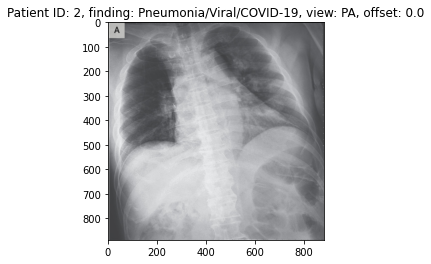

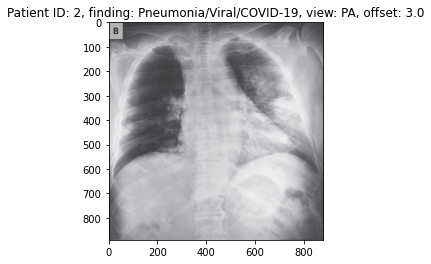

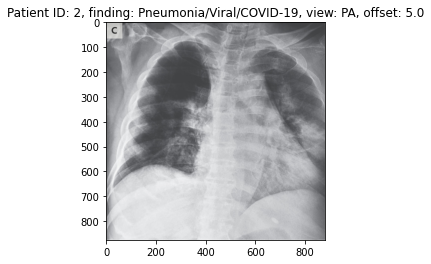

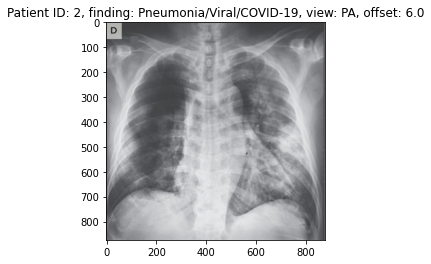

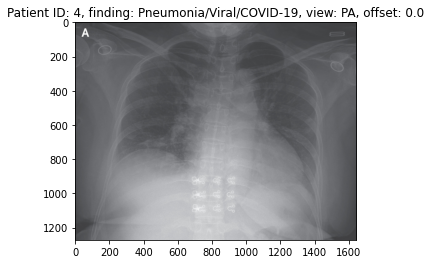

In [21]:
for index, case in covid_metadata.head(5).iterrows():
  image_path = covid_images_path / case["filename"]
  plt.figure()
  plt.title("Patient ID: {0}, finding: {1}, view: {2}, offset: {3}".format(case["patientid"],case["finding"],case["view"],case["offset"]))
  plt.imshow(plt.imread(image_path),cmap='gray')
plt.show()

#### Filter Covid-19 Dataset
Write your own code to filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views.

Return a dataframe that contains finding/full filepath as in the following figure: 
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [22]:
### Fill in your code
#Filtering data to contain only "PA" view
data_1 = {'finding': [], 'filepath': []}  
for index, case in covid_metadata.iterrows():
  image_path = covid_images_path / case["filename"]
  finding = case["finding"]
  if case["view"] == 'PA':
    data_1['finding'].append(finding)
    data_1['filepath'].append(str(image_path))
    
df = pd.DataFrame(data_1)  
print(df)

                      finding  \
0    Pneumonia/Viral/COVID-19   
1    Pneumonia/Viral/COVID-19   
2    Pneumonia/Viral/COVID-19   
3    Pneumonia/Viral/COVID-19   
4    Pneumonia/Viral/COVID-19   
..                        ...   
339  Pneumonia/Viral/COVID-19   
340  Pneumonia/Viral/COVID-19   
341  Pneumonia/Viral/COVID-19   
342  Pneumonia/Viral/COVID-19   
343                 Pneumonia   

                                              filepath  
0    covid-chestxray-dataset/images/auntminnie-a-20...  
1    covid-chestxray-dataset/images/auntminnie-b-20...  
2    covid-chestxray-dataset/images/auntminnie-c-20...  
3    covid-chestxray-dataset/images/auntminnie-d-20...  
4    covid-chestxray-dataset/images/nejmc2001573_f1...  
..                                                 ...  
339       covid-chestxray-dataset/images/16953_4_1.jpg  
340       covid-chestxray-dataset/images/16953_5_1.jpg  
341  covid-chestxray-dataset/images/2edb88df42cab5e...  
342       covid-chestxray-dataset

Filter your dataframe so it contains only COVID-19 cases:

In [23]:
### Fill in your code
#Filtering data to contain only "COVID-19"
for idx_row, row in df.iterrows():
  finding = row['finding']
  if 'COVID-19' not in finding:
    df = df.drop([idx_row])
print(df)

                      finding  \
0    Pneumonia/Viral/COVID-19   
1    Pneumonia/Viral/COVID-19   
2    Pneumonia/Viral/COVID-19   
3    Pneumonia/Viral/COVID-19   
4    Pneumonia/Viral/COVID-19   
..                        ...   
338  Pneumonia/Viral/COVID-19   
339  Pneumonia/Viral/COVID-19   
340  Pneumonia/Viral/COVID-19   
341  Pneumonia/Viral/COVID-19   
342  Pneumonia/Viral/COVID-19   

                                              filepath  
0    covid-chestxray-dataset/images/auntminnie-a-20...  
1    covid-chestxray-dataset/images/auntminnie-b-20...  
2    covid-chestxray-dataset/images/auntminnie-c-20...  
3    covid-chestxray-dataset/images/auntminnie-d-20...  
4    covid-chestxray-dataset/images/nejmc2001573_f1...  
..                                                 ...  
338       covid-chestxray-dataset/images/16953_3_1.jpg  
339       covid-chestxray-dataset/images/16953_4_1.jpg  
340       covid-chestxray-dataset/images/16953_5_1.jpg  
341  covid-chestxray-dataset/imag

#### Train, Validation, and Test Split
split the data into train, validation, and test data, and explain your method (inclouding pros and cons)

We have used the known split method (built-in function of sklearn). The advantage of using the validation set is that if we will use the test set to examine our model (without a validation set), we may encounter overfitting phenomena over the test data, which in turn will lead to good performance over the test set, this phenomena may occur because we are tuning our model to achieve good performance over a specific set of test samples. 
This is a problem because the main reason that we are using a test set is to evaluate our model performance over an unseen data,
i.e., we test how well the training procedure will be able to generalize for unseen samples. 
We can avoid this issue by examing our model performance (during the building procedure) via another set which we call the "validation" set. The validation dataset is different from the test dataset, 
both datasets are held back from the training of the model, but the validation set is used to give an unbiased performance estimation
of the final tuned model when comparing different final models.


In [24]:
### Fill in your code
#Splitting the data into 10% test, 10% validation, and 80% train
from sklearn.model_selection import train_test_split
df_train1, df_rest1 = train_test_split(df, test_size=0.2, shuffle='True', random_state=40)
df_valid1, df_test1 = train_test_split(df_rest1, test_size=0.5, shuffle='True', random_state=40)

print(f'In our dataset set we have {len(df)} samples')
print(f'In our train set we have {len(df_train1)} samples')
print(f'In our validation set we have {len(df_valid1)} samples')
print(f'In our test set we have {len(df_test1)} samples')

In our dataset set we have 196 samples
In our train set we have 156 samples
In our validation set we have 20 samples
In our test set we have 20 samples


### Load Pneumonia and Normal chest X-Ray

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [25]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [26]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


##### Using the Kaggle API

For a more complete list of what you can do with the API, visit https://github.com/Kaggle/kaggle-api.

##### Downloading Pneumonia and Normal chest X-Ray dataset

In [27]:
!kaggle datasets download "tolgadincer/labeled-chest-xray-images"

 99% 1.17G/1.17G [00:05<00:00, 173MB/s]
100% 1.17G/1.17G [00:05<00:00, 246MB/s]


In [28]:
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

##### Create Train and Test DataFrames 
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe. Be sure it is of the same format of the covid 19 dataframe: 
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

The training, validation, and test are approximatly divided into 80%, 10%, 10%, respectively

In [29]:
### Fill in your code
PATH_TRAIN = '/content/chest_xray/train'
PATH_TEST = '/content/chest_xray/test'

def generate_dataframe(PATH):
  """
  Generating data frame as requested for the Chest X-Ray images
  """
  data = {'finding': [], 'filepath': []}  
  for subdir, dirs, files in os.walk(PATH):
      for dir in dirs:
        currnet_path = os.path.join(PATH, dir)
        for file in os.listdir(currnet_path):
          full_path = os.path.join(currnet_path, file)
          if dir == 'NORMAL':
            data['finding'].append('NORMAL')
            data['filepath'].append(str(full_path))
          elif file.startswith('BACTERIA'):
            data['finding'].append('BACTERIA')
            data['filepath'].append(str(full_path))
  return pd.DataFrame(data)

df_train2, df_valid2 = train_test_split(generate_dataframe(PATH_TRAIN), test_size=1/9, shuffle='True', random_state=40)
df_test2 = generate_dataframe(PATH_TEST)
print(f'Number of samples in our train set is: {len(df_train2)}')
print(f'Number of samples in our validation set is: {len(df_valid2)}')
print(f'Number of samples in our test set is: {len(df_test2)}')


Number of samples in our train set is: 3455
Number of samples in our validation set is: 432
Number of samples in our test set is: 476


## Create a full dataset





concatenate the dataframes into one 3 dataframes: Test, valid, Train

---



In [30]:
### Fill in your code
#Concatenating both dataset into a single large dataset and then shuffle the data
train = pd.concat([df_train1, df_train2])
valid = pd.concat([df_valid1, df_valid2])
test = pd.concat([df_test1, df_test2])
train = train.sample(frac=1, random_state=40)
valid = valid.sample(frac=1, random_state=40)
test = test.sample(frac=1, random_state=40)

print(f'Number of samples in our train set is: {len(train)}')
print(f'Number of samples in our validation set is: {len(valid)}')
print(f'Number of samples in our test set is: {len(test)}')


Number of samples in our train set is: 3611
Number of samples in our validation set is: 452
Number of samples in our test set is: 496


For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [31]:
finding_to_label = {'NORMAL':0,
 'BACTERIA':1,
 'Pneumonia/Viral/COVID-19':2}
label_to_finding = {v: k for k, v in finding_to_label.items()}
### Fill in your code
train['finding'] = train['finding'].map(finding_to_label)
valid['finding'] = valid['finding'].map(finding_to_label)
test['finding'] = test['finding'].map(finding_to_label)


## Exlpore the data

### Show Data Statistics 
Plot a histogram of the data and explain your results 

### Training data distribution

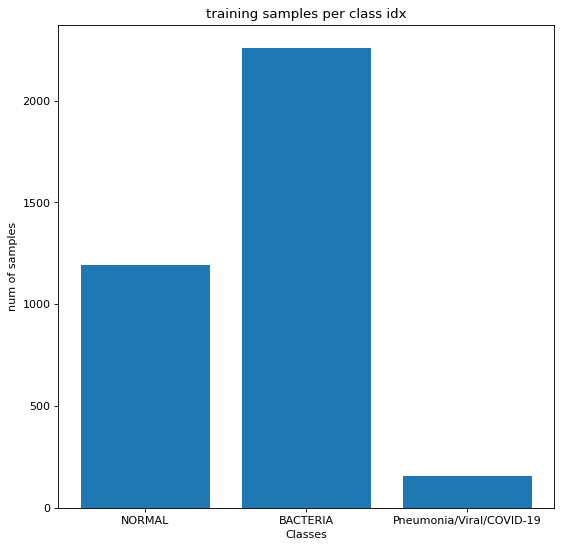

In [32]:
### Fill in your code
classes_names = finding_to_label.keys()
freq_vec = []
for j in range(3):
  freq_vec.append(Counter(train['finding'])[j])

plt.figure(figsize=(8, 8), dpi=80)
plt.title("training samples per class idx")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(classes_names, freq_vec)
plt.show() 

1    2261
0    1194
2     156
Name: finding, dtype: int64


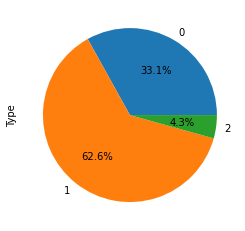

In [33]:
print(train['finding'].value_counts())
train.groupby('finding').size().plot(kind='pie',
                                     y = "finding",
                                     label = "Type",
                                     autopct='%1.1f%%')

### Validation data distribution

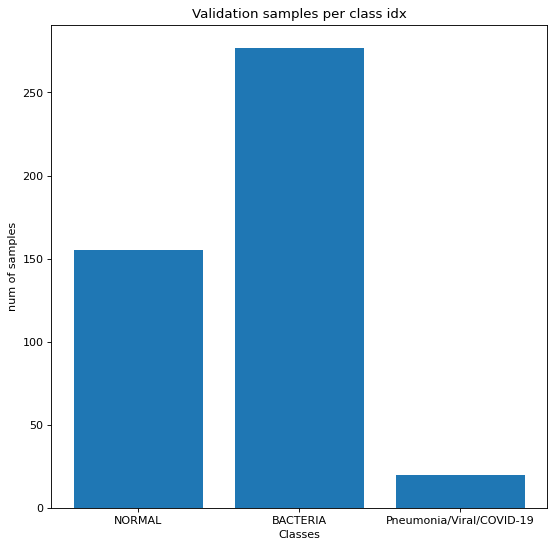

In [34]:
classes_names = finding_to_label.keys()
freq_vec_valid = []
for j in range(3):
  freq_vec_valid.append(Counter(valid['finding'])[j])
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Validation samples per class idx")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(classes_names, freq_vec_valid)
plt.show() 

1    277
0    155
2     20
Name: finding, dtype: int64


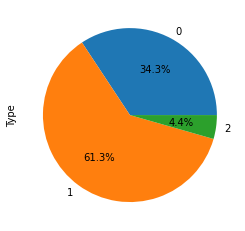

In [35]:
print(valid['finding'].value_counts())
valid.groupby('finding').size().plot(kind='pie',
                                     y = "finding",
                                     label = "Type",
                                     autopct='%1.1f%%')

### Test data distribution

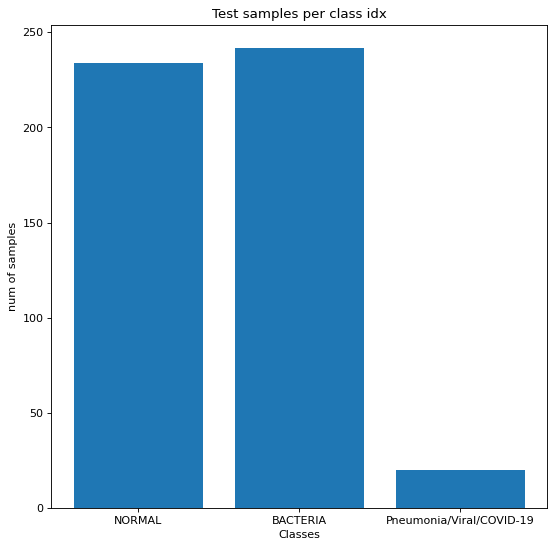

In [36]:
classes_names = finding_to_label.keys()
freq_vec_test = []
for j in range(3):
  freq_vec_test.append(Counter(test['finding'])[j])
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Test samples per class idx")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(classes_names, freq_vec_test)
plt.show() 

1    242
0    234
2     20
Name: finding, dtype: int64


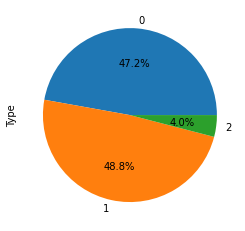

In [37]:
print(test['finding'].value_counts())
test.groupby('finding').size().plot(kind='pie',
                                     y = "finding",
                                     label = "Type",
                                     autopct='%1.1f%%')

**Fill your answers here:**
As we can see, our dataset is imbalanced. It's known that imbalanced data causes problems in the classification tasks.
For instance, consider the case of classifying dogs and cats, and our dataset contains a single sample of cat, in that case, there is a concern that the model will learn to predict dogs regardless of what the input is. furthermore, in this case, the accuracy of the model over the training set will be almost 100% even though the model is poor. In general, we would like the dataset to be balanced.

In our example, Covid-19 examples are only 4.3% of the whole training dataset and Normal examples are 33.1% of the training dataset. As most of the dataset has Bacteria examples, it will probably lead to a low accuracy over the Covid-19 and Normal classes, and high accuracy over the Bacteria class.

Another insight is that the distributions of the validation set and train set are similar, but the distributions of the validation set and the test set are not similar. In the training/validation sets, the number of Normal examples is approximately half of the Bacteria samples, whereas in the test set their sizes are almost identical. Because the dataset is imbalanced, and the distribution of the test set is different from the distribution of the validation set which is similar to those of the training set, we expect that the performance over the validation set will be close to those of the training set, and the performance over the test set will be worse than the results over the training/validation sets.


### Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

In [ ]:
### Fill in your code
NORMAL_path = []
BACTERIA_path = []
Pneumonia_COVID_19_path = []
N = 16 # number of images per class

for idx, row in train.iterrows():
  label = row['finding']
  finding = label_to_finding[label]
  if finding == 'NORMAL' and len(NORMAL_path) < N:
    NORMAL_path.append(row['filepath'])
  if finding == 'BACTERIA' and len(BACTERIA_path) < N:
    BACTERIA_path.append(row['filepath'])
  if finding == 'Pneumonia/Viral/COVID-19' and len(Pneumonia_COVID_19_path) < N:
    Pneumonia_COVID_19_path.append(row['filepath'])


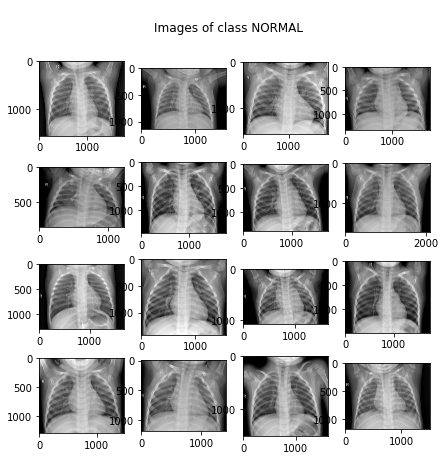

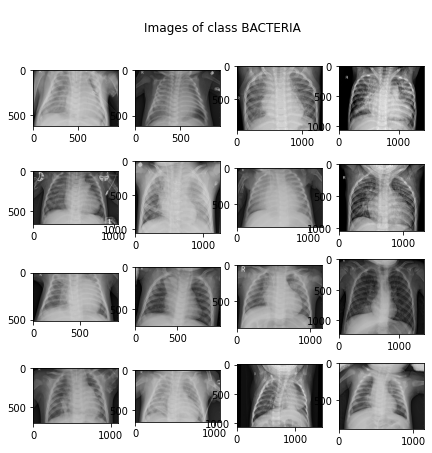

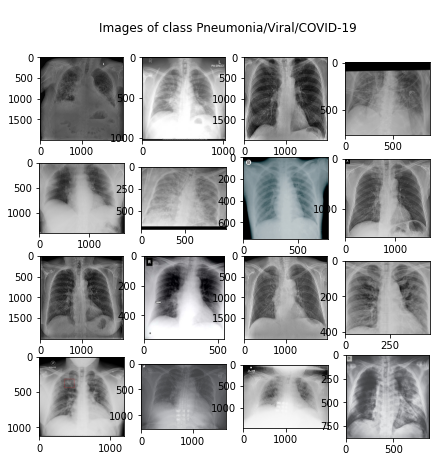

In [ ]:
def plot_images(PATH, label):
  fig=plt.figure(figsize=(7, 7))
  for i in range(0, N):
      ax=fig.add_subplot(4,4,i+1)        
      ax.imshow(plt.imread(PATH[i]),cmap='gray')
  finding = label_to_finding[label] 
  fig.suptitle(f'\nImages of class {finding}')
  plt.show()

plot_images(NORMAL_path, 0)
plot_images(BACTERIA_path, 1)
plot_images(Pneumonia_COVID_19_path, 2)

**Fill your answers here:**
We observe that the COVID images have different brightness to some extent. The problem is that the model may learn to predict COVID-19 according to the machine that took the images, which is undesired. One solution is to apply augmentations of brighneness to the whole dataset

# Dealing with imbalanced data
There are many methods to try and overcome this problem, we will try 3 methods , all methods will be preformed solely on the train data:

*  **Under sampling:** Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when quantity of data is sufficient. By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class.

*  **Over sampling:** Over-sampling is used when the quantity of data is insufficient. It tries to balance dataset by increasing the size of rare samples. Rather than getting rid of abundant samples

* **Class weights:** Class weights tries to balance the data without changing the data itself. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase.







## Use the 3 different methods in your training

Create an over sampled train set and a under sampled train set.

#### Under sampling

In [ ]:

#set the majorities classes to a seperate dataframe
df_major0 = train[train['finding'] == 0]
df_major1 = train[train['finding'] == 1]

#set other classes to another dataframe
other_df = train[train['finding'] == 2]  

#down sample the majority classes to size of minority class 
df_major0_downsampled = resample(df_major0,random_state=42,n_samples=freq_vec[2],replace=True)
df_major1_downsampled = resample(df_major1,random_state=42,n_samples=freq_vec[2],replace=True)

#concatenate the downsampled dataframe
train_downsampled = pd.concat([df_major0_downsampled, df_major1_downsampled, other_df])


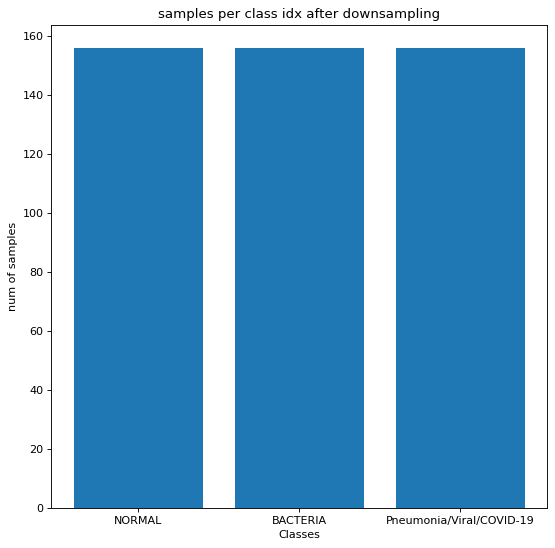

In [ ]:
### Fill in your code
classes_names = finding_to_label.keys()
freq_vec_under_sampling = []
for j in range(3):
  freq_vec_under_sampling.append(Counter(train_downsampled['finding'])[j])

plt.figure(figsize=(8, 8), dpi=80)
plt.title("samples per class idx after downsampling")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(classes_names, freq_vec_under_sampling)
plt.show() 

0    156
1    156
2    156
Name: finding, dtype: int64


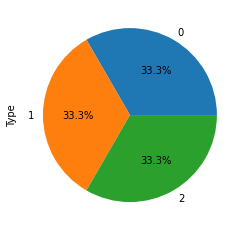

In [ ]:
print(train_downsampled['finding'].value_counts())
train_downsampled.groupby('finding').size().plot(kind='pie',
                                     y = "finding",
                                     label = "Type",
                                     autopct='%1.1f%%')

#### Over sampling

In [ ]:

#set the minority classes to a seperate dataframe
df_minor0 = train[train['finding'] == 0]
df_minor2 = train[train['finding'] == 2]

#set other classes to another dataframe
other_df = train[train['finding'] == 1]  

#oversample the minority class, we upsample the minority class to size of BACTERIA class
df_minor0_upsampled = resample(df_minor0,random_state=42,n_samples=freq_vec[1],replace=True)
df_minor2_upsampled = resample(df_minor2,random_state=42,n_samples=freq_vec[1],replace=True)

#concatenate the upsampled dataframe
train_upsampled = pd.concat([df_minor0_upsampled, df_minor2_upsampled, other_df])


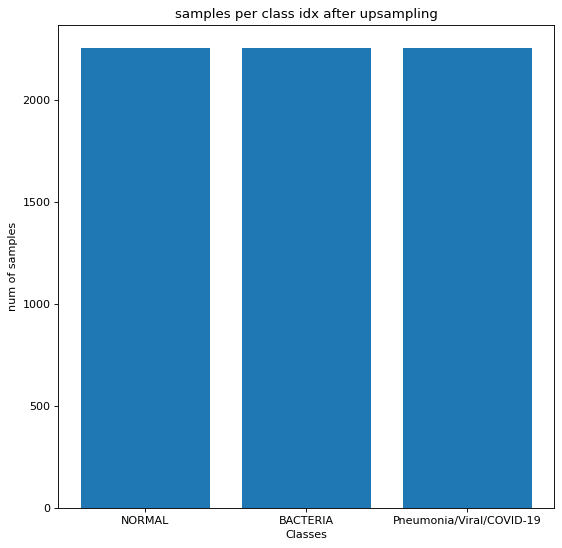

In [ ]:
### Fill in your code
classes_names = finding_to_label.keys()
freq_vec_over_sampling = []
for j in range(3):
  freq_vec_over_sampling.append(Counter(train_upsampled['finding'])[j])

plt.figure(figsize=(8, 8), dpi=80)
plt.title("samples per class idx after upsampling")
plt.xlabel("Classes")
plt.ylabel("num of samples")
plt.bar(classes_names, freq_vec_over_sampling)
plt.show() 

0    2256
2    2256
1    2256
Name: finding, dtype: int64


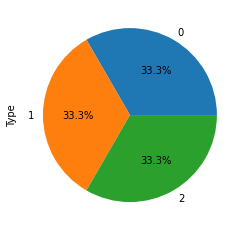

In [ ]:
print(train_upsampled['finding'].value_counts())
train_upsampled.groupby('finding').size().plot(kind='pie',
                                     y = "finding",
                                     label = "Type",
                                     autopct='%1.1f%%')

#### Classes Weights

The formula for calculating this is:

$w_j$ = n_samples/(n_classes * n_samples_class_j)

$w_j$ is the weight for each class ($j$ signifies the class)

*   **n_samples** is the total number of samples or rows in the dataset

*   **n_classes** is the total number of unique classes in the target

*   **n_samples_class_j** is the total number of samples of the respective class


In [ ]:
class_weights = {}
for class_idx in range(3):
  class_weights[class_idx] = len(train) / (freq_vec[class_idx] * 3) # 3 classes we have

In [ ]:
class_weights

{0: 1.0038921323324994, 1: 0.5335401891252955, 2: 7.715811965811966}

This is a standard classes weight method. Noth that the smaller the number of class instances, the larger the weight for this class.
The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

The classes weights are combined with the loss as follow:
Assuming a binary cross entropy loss with a single sample for ease of notations.
Without class weights - $L=-\big{(}plog(\hat{p})+(1-p)log(1-\hat{p})\big{)}$.
If the class corresponded to $p$, is with weight $w_0$, and the class corresponded to $1-p$, is with weight $w_1$, then the weighed loss is expressed by
$L=-\big{(}w_0\cdot p\cdot log(\hat{p})+w_1\cdot (1-p)\cdot log(1-\hat{p})\big{)}$.

# Create tf.Dataset
Create a tf.Dataset object from the train data, in which every entry has the label and the image.
Repeat for validation data.

Steps:
1.   Create a tf.dataset object from the dataframe. [1]
2.   Write a function that parse the data from each dataset entry to class/image [2]
3.   Apply the function on the dataset using tf.Dataset.map [2]

See:

[1] tf.dataset from pandas dataframe : https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#load_data_using_tfdatadataset
[2] Image loading : https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata

* **Step 1 - Create a tf.dataset object from the dataframe, each entry should contain filename and class.**

In [ ]:
### Fill in your code
train_ds = tf.data.Dataset.from_tensor_slices((train['filepath'],train['finding']))
train_ds_downsampled = tf.data.Dataset.from_tensor_slices((train_downsampled['filepath'],train_downsampled['finding']))
train_ds_upsampled = tf.data.Dataset.from_tensor_slices((train_upsampled['filepath'],train_upsampled['finding']))

  Test your dataset object:

In [ ]:
for filename, label in train_ds.take(5):
  print ('Filename: {}, Label: {}'.format(filename, label))

Filename: b'/content/chest_xray/train/PNEUMONIA/BACTERIA-4521338-0004.jpeg', Label: 1
Filename: b'/content/chest_xray/train/NORMAL/NORMAL-5752258-0001.jpeg', Label: 0
Filename: b'/content/chest_xray/train/PNEUMONIA/BACTERIA-5150733-0010.jpeg', Label: 1
Filename: b'/content/chest_xray/train/PNEUMONIA/BACTERIA-5476259-0006.jpeg', Label: 1
Filename: b'/content/chest_xray/train/NORMAL/NORMAL-7301799-0001.jpeg', Label: 0


* **Step 2 - Write a function to parse the image file name and return a grayscale image , resized to 512X512**.

> The mapping function will run each time a batch is fetched. the input is your dataset entry - (filepath,label) and the output should be (img,label).
\
Note that once the you read the image using tensorflow (tf.io.read_file), your operations should be on Tensors. 

> You can use a mapping function to tranform the data randomly each time a batch is fetched for data augmentation. 
https://www.tensorflow.org/tutorials/images/data_augmentation


**We resized the images to 128X128 to allowing cache the data on the avilable RAM in Colab. This also allowed the model trained faster, and we still get pretty good results.**

In [ ]:
### Student code
def decode_img(img):
  """
  preprocess images
  """
  img_content = tf.io.read_file(img) #read the image from the path
  image = tf.image.decode_jpeg(img_content,channels=3) 
  image_gs = tf.image.rgb_to_grayscale(image) #rgb to gray
  image_resized=tf.image.resize(image_gs,(128, 128)) #resize to prevent colab RAM error 
  return image_resized


def map_function(filename,label):
  return decode_img(filename),int(label)


* Step 3 - Apply the mapping function on the dataset

In [ ]:
### Fill in your code
# Decoding the training sets
train_ds = train_ds.map(map_function)
train_ds_downsampled = train_ds_downsampled.map(map_function)
train_ds_upsampled = train_ds_upsampled.map(map_function)


Test your dataset:


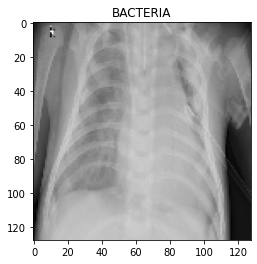

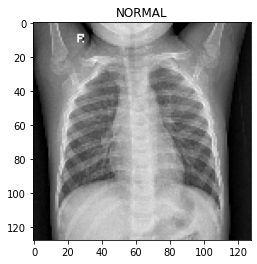

In [ ]:
for image, label in train_ds.take(2):
  plt.figure()
  plt.imshow(image.numpy().squeeze(),cmap='gray')
  plt.title(label_to_finding[label.numpy()])
plt.show()

Repeat the steps for the validation set.

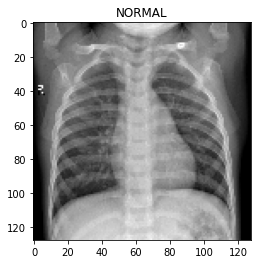

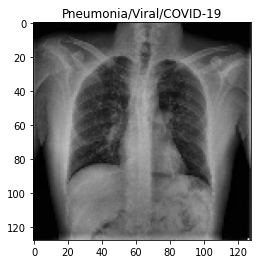

In [ ]:
### Fill in your code
valid_ds = tf.data.Dataset.from_tensor_slices((valid['filepath'], valid['finding']))
valid_ds = valid_ds.map(map_function)
for image, label in valid_ds.take(2):
  plt.figure()
  plt.imshow(image.numpy().squeeze(),cmap='gray')
  plt.title(label_to_finding[label.numpy()])
plt.show()

test_ds = tf.data.Dataset.from_tensor_slices((test['filepath'], test['finding']))
test_ds = test_ds.map(map_function)

#Data Augmentation

Now, we want to add data augmentation to the training set.



\
Write a function that operates on entries of your dataset, and augments them, and then apply this function to your dataset.

You can use functions from tf.image.random_* to randomly augment your data as you process it.
For example, to randomly flip your image:

```
  img = tf.image.random_flip_left_right(img)
```



Explain the purpose of the chosen augmentation with an emphasis on the particular task.

The prior work ("*Data Augmentation for Chest Pathologies Classification*", 2019, http://dx.doi.org/10.1109/ISBI.2019.8759573), motivated our choice of data augmentations. According to the paper, augmentations that did not result in statistically significant improvements were random contrast and blur. On the other hand, augmentations with performance improvements were gamma, brightness, and flip.
Thus, we applied the following augmentations to our dataset:

* *random_flip_left_right* - Randomly flip an image horizontally (left to right)
* *adjust_gamma* - Performs Gamma Correction on the input image.
* *random_brightness* - Adjust the brightness of images by a random factor.



In [ ]:
def augmentation(img, label):
  aug_img=tf.image.random_flip_left_right(img)
  gamma = np.random.uniform(low=0.9, high=1.1, size=[1,])
  aug_img=tf.image.adjust_gamma(aug_img, gamma=gamma[0], gain=1)
  aug_img=tf.image.random_brightness(aug_img,0.1)
  return aug_img,label

aug_train_ds = train_ds.map(augmentation)

Test your data augmentation.
\
We will process the same entry several times and should see different results.

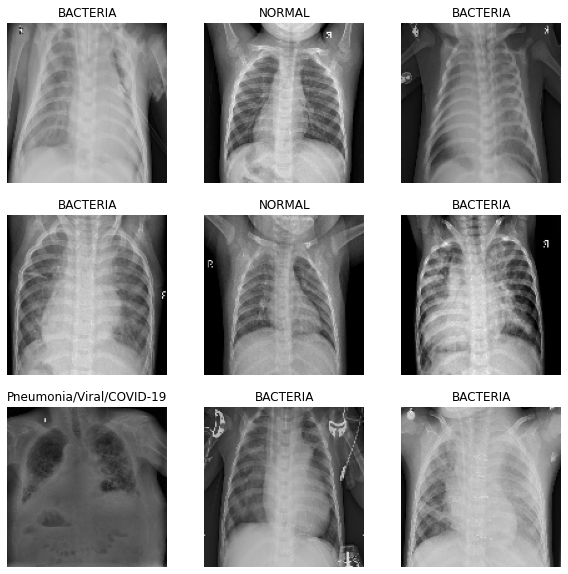

In [ ]:
N = 9 # number of images
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(aug_train_ds.take(N)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image.numpy().squeeze(),cmap='gray')
  plt.title(label_to_finding[label.numpy()])
  plt.axis('off')
plt.show()

# Prepare datasets for training
So far we defined datasets that can be used for training, but are not yet ready to process large amounts of data fast.

\\
We would like to make our dataset ready for fast batch processing.
The following function does that:
*   Cache your data - load it to your RAM/save it to file for faster access.
*   Shuffle your data.
*   Repeat the data - makes the iterator cyclic, so it will be repeated after each epoch, making an "infinite" dataset. This may be ommited, but the training process may differ.
*   Batch the data - fetch the data in batches, each batch has batch_size entries.
*   Prefetch the data - while you process one batch, the CPU will prefetch the next batches (including preprocessing and augmentations)


for further reading - https://www.tensorflow.org/guide/data


In [ ]:
#Source https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata
def prepare_for_training(ds,batch_size=32, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

#### Apply augmentation over the train set

In [ ]:
aug_train_ds_upsampled = train_ds_upsampled.map(augmentation)
aug_train_ds_downsampled = train_ds_downsampled.map(augmentation)

In [ ]:
# Apply on your dataset
prepared_train_ds = prepare_for_training(aug_train_ds)
prepared_valid_ds = prepare_for_training(valid_ds)
prepared_train_ds_upsampled = prepare_for_training(aug_train_ds_upsampled)
prepared_train_ds_downsampled = prepare_for_training(aug_train_ds_downsampled)

Visualize results

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n],cmap='gray')
      plt.title(label_to_finding[label_batch[n]])
      plt.axis('off')

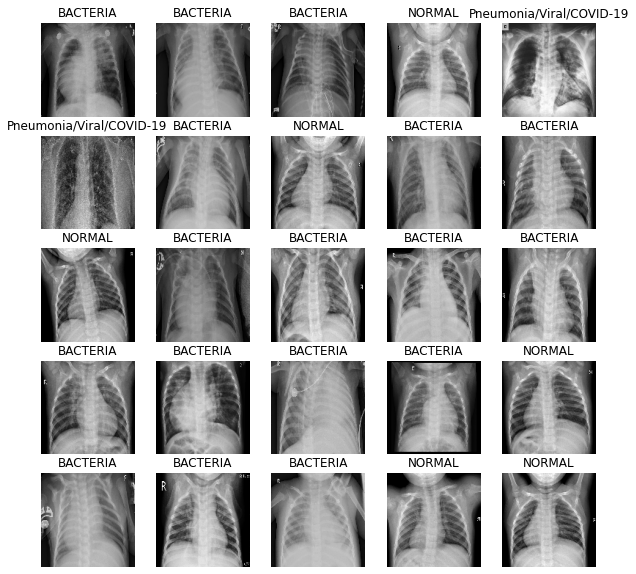

In [ ]:
image_batch, label_batch = next(iter(prepared_train_ds))
show_batch(image_batch.numpy().squeeze(), label_batch.numpy())

# Choosing a Model

In this section, we determine our model to be used as the classifier by comparing the results of various configurations: 


* Vanilla Model
* Downsampled Model
* Upsampled Model
* Class weights Model
* Modified ResNet50 Model using Transfer Learning

The first 4 "models" mentioned above are actually the same model architecture but, with a different datasets or with class weights.

## Train a classification network

Now that you have a dataset ready, you are steps away from training your own classification network to help detect COVID-19 cases!


*   Build your CNN classification model and fit it.
*   Add data augmentations




In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(84, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)   #3 classes problem 
])
#Create differrent copies of the model
ds_model = tf.keras.models.clone_model(model) # downsamples model
us_model = tf.keras.models.clone_model(model) # upsample model
cw_model = tf.keras.models.clone_model(model) # class weight model

In [ ]:
epoches = 10
batch_size = 32

In [ ]:
# Compile and fit your model

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
              metrics=['accuracy'])

log_dir_basic = "logs/fit/Vanilla_Training/basic_" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback_basic = tf.keras.callbacks.TensorBoard(log_dir=log_dir_basic, histogram_freq=1)

print("Basic model after augmentation")
history_basic = model.fit(
    prepared_train_ds,
    validation_data = prepared_valid_ds,
    steps_per_epoch = len(train) // batch_size,
    validation_steps = len(valid) // batch_size,
    epochs = epoches,
    callbacks=[tensorboard_callback_basic]
)


Basic model after augmentation
Epoch 1/10
112/112 [==============================] - 4s 29ms/step - loss: 0.7889 - accuracy: 0.8373 - val_loss: 0.5438 - val_accuracy: 0.8080
Epoch 2/10
112/112 [==============================] - 3s 27ms/step - loss: 0.1727 - accuracy: 0.9406 - val_loss: 0.4658 - val_accuracy: 0.7991
Epoch 3/10
112/112 [==============================] - 4s 34ms/step - loss: 0.1413 - accuracy: 0.9473 - val_loss: 0.5040 - val_accuracy: 0.8170
Epoch 4/10
112/112 [==============================] - 4s 35ms/step - loss: 0.1008 - accuracy: 0.9632 - val_loss: 0.2597 - val_accuracy: 0.9040
Epoch 5/10
112/112 [==============================] - 4s 35ms/step - loss: 0.0830 - accuracy: 0.9707 - val_loss: 0.0954 - val_accuracy: 0.9643
Epoch 6/10
112/112 [==============================] - 4s 34ms/step - loss: 0.0804 - accuracy: 0.9693 - val_loss: 0.0920 - val_accuracy: 0.9621
Epoch 7/10
112/112 [==============================] - 3s 28ms/step - loss: 0.0661 - accuracy: 0.9768 - val_loss


Evaluate your models using different measures:
* Confusion matrix
* Accuracy
* Precision
* Recall (Sensitivity)
* Specificity
* tsne





**Confusion matrix** - A confusion matrix is a technique for summarizing the performance of a classification algorithm. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. 

**Accuracy** - Accuracy is the number of correctly predicted data points out of all the data points. More formally, it is defined as the number of true positives and true negatives divided by the number of true positives, true negatives, false positives, and false negatives.

**Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

**Recall** (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

**F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. Therefore, in our case F1 score is prefered.

**Specificity** - Specificity of a classifier is the ratio between how much were correctly classified as negative to how much was actually negative.



In [ ]:
def class_splitter(images, labels, classes=3):
    """
    This function creates  a list of images per class
    """
    test_images_new = [[] for _ in range(classes)]
    label_list = [[] for _ in range(classes)]
    for idx, label in enumerate(labels):
          test_images_new[label].append(images[idx]) 
    for label in range(classes):
        label_list[label] =  [label for i in range(len(test_images_new[label]))]
    test_images_new = [np.array(i) for i in test_images_new]
    label_list = [np.array(i) for i in label_list]
    return np.array(test_images_new), np.array(label_list)


def accuracy_per_class_plot(test_images_new, label_list, model,class_names=[0,1,2] ):
    """
    This function calculates the accuracy per class and plot it as bar plot
    """
    test_loss = [ 0 for i in range(len(class_names))]
    test_acc = [ 0 for i in range(len(class_names))]
    for label, cls in enumerate(class_names):
        test_loss[label], test_acc[label] = model.evaluate(test_images_new[label],  label_list[label], verbose=0)
        print(f'Test accuracy for class {cls} is:\n', test_acc[label])
        
    plt.figure(figsize=(8, 8), dpi=80)
    plt.title("Accuracy per class idx")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.bar(class_names , test_acc)
    plt.show() 

def confusion_matrix_plot(labels, predicted_labels, class_names):
    """
    This function creates and plot the confusion matrix.
    A confusion matrix is a technique for summarizing the performance of a classification algorithm
    """
    result = tf.math.confusion_matrix(labels, predicted_labels)
    ax = sns.heatmap(result, annot=True, cmap='Blues', fmt='1d')
    ax.set_title('Confusion metrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Ground truth ');
    ax.xaxis.set_ticklabels(class_names, rotation=10)
    ax.yaxis.set_ticklabels(class_names, rotation=10)
    plt.show()

def generate_tsne(model, data, labels, LOG_DIR, classes_names, model_name):

  # creating a new model by removing the last layer
  cust_model = tf.keras.models.Sequential()
  for layer in model.layers[:-1]:
    cust_model.add(layer)

  features_vec = cust_model.predict(data)
  model_name_tsne = f"features_vectors_{model_name}.pkl"
  pickle.dump(features_vec, open(model_name_tsne, 'wb'))

  # creating metadata file that contain the corresponding label
  # for each image in the dataset
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

  metadata_file = open(os.path.join('/content', LOG_DIR, 'metadata_3_classes_chest_xray.tsv'), 'w', encoding='utf-8')
  metadata_file.write('Class\tName\n')

  for idx in labels:
    label = idx
    name = classes_names[idx]
    metadata_file.write('{}\t{}\n'.format(label, name))
  metadata_file.close()

  # set the config and visualize
  with open(model_name_tsne, 'rb') as f:
    features_vectors = pickle.load(f)
  features = tf.Variable(features_vectors, name='features')
  checkpoint = tf.train.Checkpoint(embedding=features)
  checkpoint.save(os.path.join(LOG_DIR, "embedding.ckpt"))
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
  embedding.metadata_path = os.path.join('/content', LOG_DIR, 'metadata_3_classes_chest_xray.tsv')
  projector.visualize_embeddings(LOG_DIR, config)
  

def calculate_specificity(test_labels, predicted_labels_basic):
  cm = metrics.confusion_matrix(test_labels, predicted_labels_basic)

  FP = cm.sum(axis=0) - np.diag(cm)  
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  Specificity = TN/(TN+FP)
  return np.round(Specificity,2)

def results_printer(model, valid_ds, classes_names, model_name, print_tsne=True):  
  #summerizes all results and prints them
  test_images = np.concatenate([np.expand_dims(x, axis=0) for x, y in valid_ds], axis=0)
  test_labels = np.concatenate([[y.numpy()] for x, y in valid_ds], axis=0)

  test_images_list, label_list = class_splitter(test_images,  test_labels)

  #Plotting accuracy per class
  print('#'*40+' Accuracy per Class '+ '#'*40)

  accuracy_per_class_plot(test_images_list, label_list, model, class_names=finding_to_label.keys() )

  #Plotting confusion matrix
  print('#'*40+' Confusion Matrix '+ '#'*40)
  predicted_labels = tf.argmax(tf.nn.softmax(model.predict(test_images)), axis=1)
  confusion_matrix_plot(test_labels, predicted_labels, classes_names)

  #printing Overall accuracy
  print('#'*40+' Total Acuuracy '+ '#'*40)
  test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
  print(f'{model_name} test accuracy: {test_acc}')
  print(classification_report(test_labels, predicted_labels, target_names=classes_names))

  #printing Specificity
  print('#'*40+' Specificity '+ '#'*40)
  Specificity = calculate_specificity(test_labels, predicted_labels)
  for label_num, spec in zip(finding_to_label.keys(), Specificity):
    print(f'Class {label_num} specificity: {spec}')

  #tsne
  if print_tsne:
    print('#'*40+' TSNE '+ '#'*40)
    classes_names = [k  for  k in  finding_to_label.keys()]
    generate_tsne(model, test_images, test_labels, 'embedding_logs_test', classes_names, model_name)
    %tensorboard --logdir='embedding_logs_test' 
  return predicted_labels, test_labels



**Please note that in the following, we took the images, saved them, and uploaded them because, otherwise, they will removed when converting to PDF. you can find the figures in the folder named by Fig, in the submitted files.**

In [ ]:
# %tensorboard --logdir logs/fit/Vanilla_Training

Loss and Accuracy for train and validation

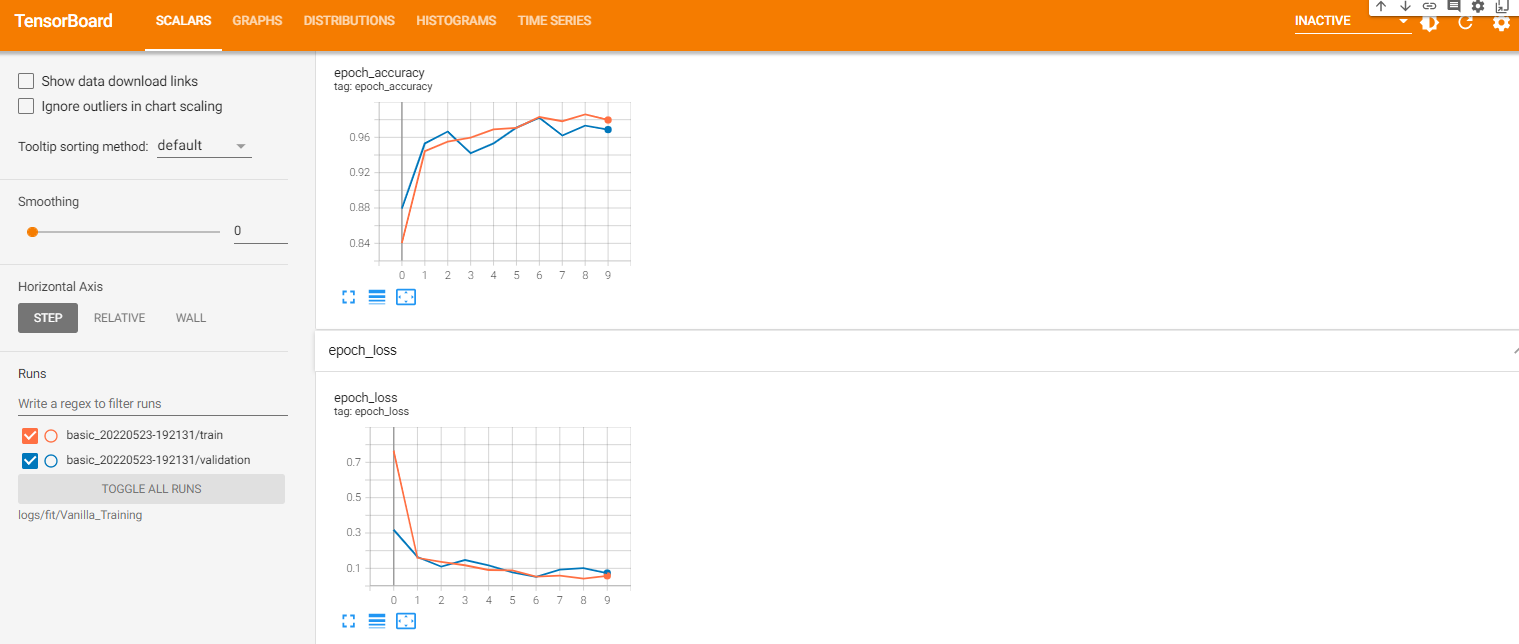

In [ ]:
from IPython.display import Image
Image(filename='figure1.png') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


######################################## Accuracy per Class ########################################
Test accuracy for class NORMAL is:
 0.2905983030796051
Test accuracy for class BACTERIA is:
 1.0
Test accuracy for class Pneumonia/Viral/COVID-19 is:
 0.949999988079071


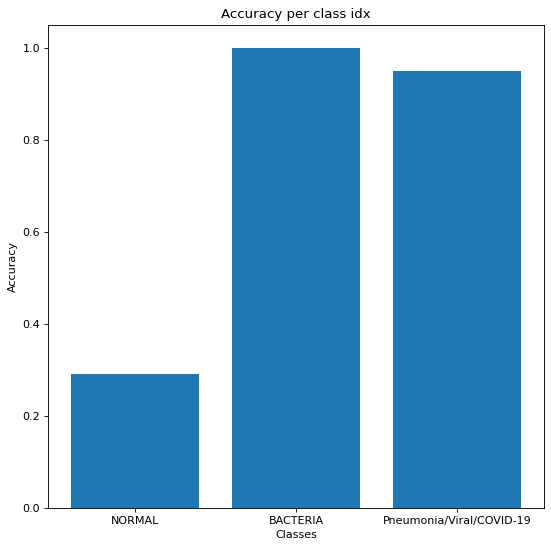

######################################## Confusion Matrix ########################################


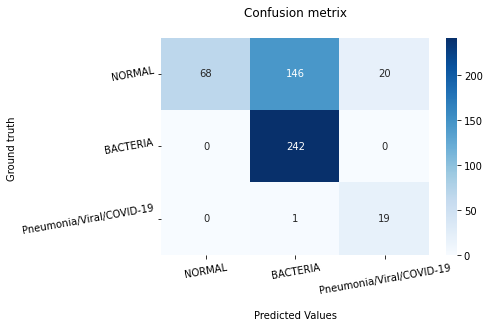

######################################## Total Acuuracy ########################################
Vanilla_Training test accuracy: 0.663306474685669
                          precision    recall  f1-score   support

                  NORMAL       1.00      0.29      0.45       234
                BACTERIA       0.62      1.00      0.77       242
Pneumonia/Viral/COVID-19       0.49      0.95      0.64        20

                accuracy                           0.66       496
               macro avg       0.70      0.75      0.62       496
            weighted avg       0.79      0.66      0.61       496

######################################## Specificity ########################################
Class NORMAL specificity: 1.0
Class BACTERIA specificity: 0.42
Class Pneumonia/Viral/COVID-19 specificity: 0.96


In [ ]:
predicted_labels, test_labels = results_printer(model, test_ds, finding_to_label.keys(), 'Vanilla_Training', print_tsne=False)

TSNE

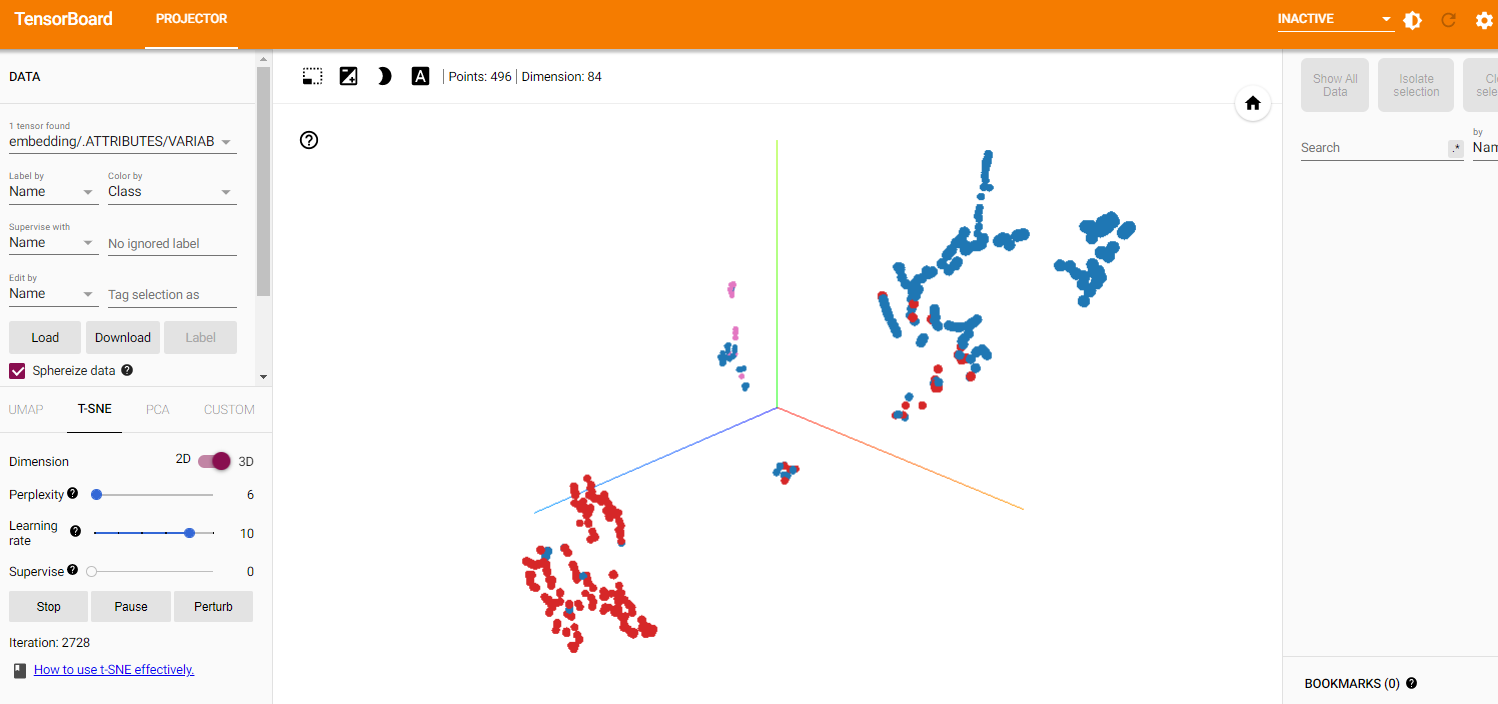

In [ ]:
Image(filename='figure2.png') 

##Downsampled model

In [ ]:
log_dir_downsampled = "logs/fit/downsampled_model/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback_downsampled = tf.keras.callbacks.TensorBoard(log_dir=log_dir_downsampled, histogram_freq=1)

print("The downsampled model")
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
ds_model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
              metrics=['accuracy'])

history_downsampled = ds_model.fit(
    prepared_train_ds_downsampled,
    validation_data = prepared_valid_ds,
    steps_per_epoch = len(train_downsampled) // batch_size,
    validation_steps = len(valid) // batch_size,
    epochs = 15,
    callbacks=[tensorboard_callback_downsampled]
)


The downsampled model
Epoch 1/15
14/14 [==============================] - 13s 91ms/step - loss: 0.8203 - accuracy: 0.6562 - val_loss: 4.5346 - val_accuracy: 0.1027
Epoch 2/15
14/14 [==============================] - 1s 79ms/step - loss: 0.4945 - accuracy: 0.8214 - val_loss: 1.1629 - val_accuracy: 0.4308
Epoch 3/15
14/14 [==============================] - 1s 76ms/step - loss: 0.2358 - accuracy: 0.9152 - val_loss: 1.2019 - val_accuracy: 0.4710
Epoch 4/15
14/14 [==============================] - 1s 75ms/step - loss: 0.1536 - accuracy: 0.9531 - val_loss: 0.7979 - val_accuracy: 0.6339
Epoch 5/15
14/14 [==============================] - 1s 79ms/step - loss: 0.1865 - accuracy: 0.9263 - val_loss: 0.6064 - val_accuracy: 0.7344
Epoch 6/15
14/14 [==============================] - 1s 80ms/step - loss: 0.1094 - accuracy: 0.9665 - val_loss: 0.4324 - val_accuracy: 0.8170
Epoch 7/15
14/14 [==============================] - 1s 79ms/step - loss: 0.1180 - accuracy: 0.9554 - val_loss: 0.4021 - val_accurac

In [ ]:
# %tensorboard --logdir logs/fit/downsampled_model

Loss and Accuracy for train and validation

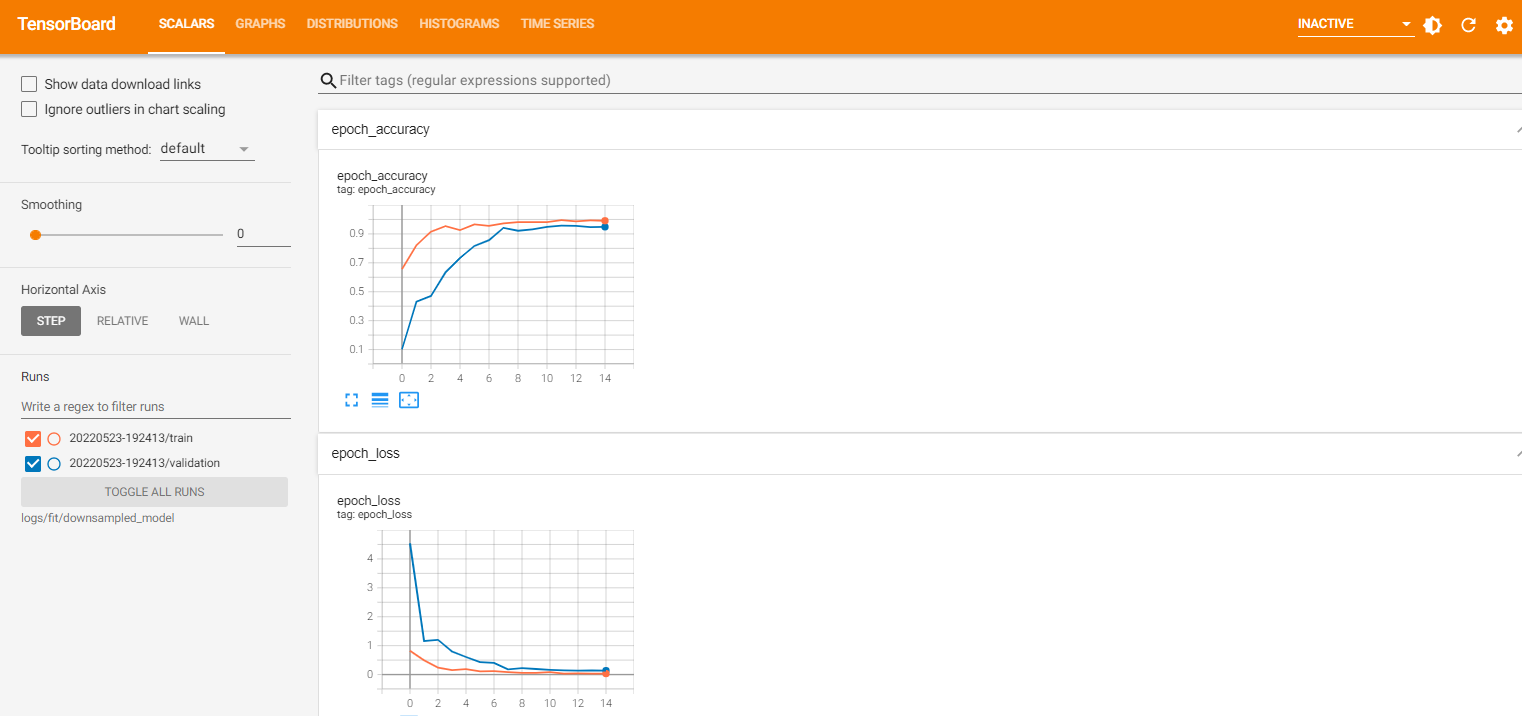

In [ ]:
Image(filename='figure3.png') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


######################################## Accuracy per Class ########################################
Test accuracy for class NORMAL is:
 0.7692307829856873
Test accuracy for class BACTERIA is:
 0.942148745059967
Test accuracy for class Pneumonia/Viral/COVID-19 is:
 1.0


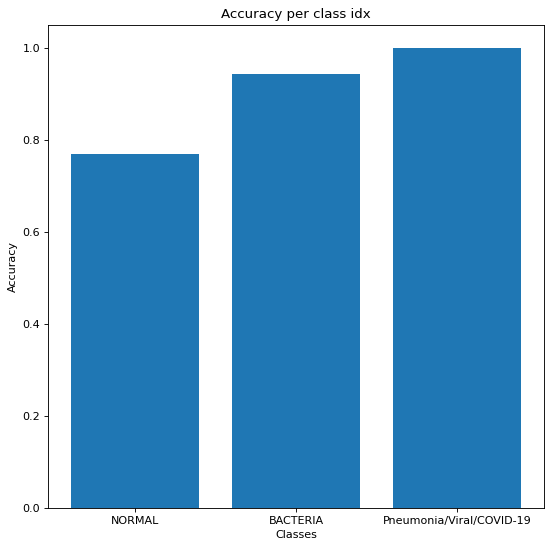

######################################## Confusion Matrix ########################################


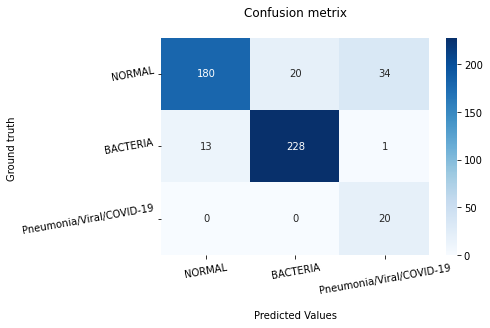

######################################## Total Acuuracy ########################################
downsampled_model test accuracy: 0.8629032373428345
                          precision    recall  f1-score   support

                  NORMAL       0.93      0.77      0.84       234
                BACTERIA       0.92      0.94      0.93       242
Pneumonia/Viral/COVID-19       0.36      1.00      0.53        20

                accuracy                           0.86       496
               macro avg       0.74      0.90      0.77       496
            weighted avg       0.90      0.86      0.87       496

######################################## Specificity ########################################
Class NORMAL specificity: 0.95
Class BACTERIA specificity: 0.92
Class Pneumonia/Viral/COVID-19 specificity: 0.93


In [ ]:
predicted_labels_downsampled, test_labels = results_printer(ds_model, test_ds, finding_to_label.keys(), 'downsampled_model' ,print_tsne=False)

TSNE

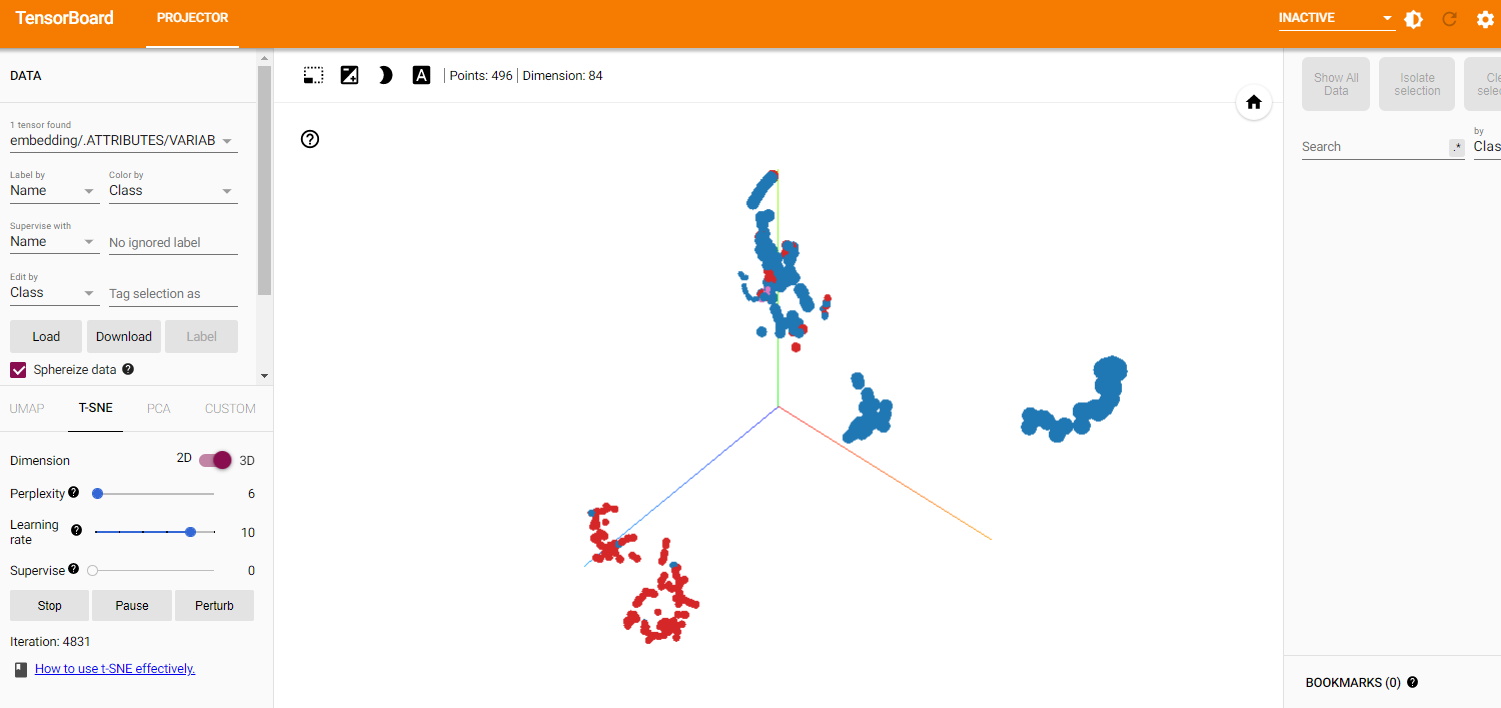

In [ ]:
Image(filename='figure4.png') 

##Upsampled model

In [ ]:
log_dir_upsampled = "logs/fit/upsampled_model/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback_upsampled = tf.keras.callbacks.TensorBoard(log_dir=log_dir_upsampled, histogram_freq=1)

print("The upsampled model")
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
us_model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
              metrics=['accuracy'])
history_upsampled = us_model.fit(
    prepared_train_ds_upsampled,
    validation_data = prepared_valid_ds,
    steps_per_epoch = len(train_upsampled) // batch_size,
    validation_steps = len(valid) // batch_size,
    epochs = epoches,
    callbacks=[tensorboard_callback_upsampled]
)


The upsampled model
Epoch 1/10
211/211 [==============================] - 165s 653ms/step - loss: 0.3245 - accuracy: 0.9025 - val_loss: 0.5877 - val_accuracy: 0.7143
Epoch 2/10
211/211 [==============================] - 4s 20ms/step - loss: 0.2950 - accuracy: 0.9070 - val_loss: 0.7004 - val_accuracy: 0.6875
Epoch 3/10
211/211 [==============================] - 4s 20ms/step - loss: 0.2786 - accuracy: 0.9060 - val_loss: 1.5024 - val_accuracy: 0.6473
Epoch 4/10
211/211 [==============================] - 4s 20ms/step - loss: 0.2648 - accuracy: 0.9174 - val_loss: 0.7082 - val_accuracy: 0.7232
Epoch 5/10
211/211 [==============================] - 4s 20ms/step - loss: 0.2626 - accuracy: 0.9113 - val_loss: 0.7556 - val_accuracy: 0.7009
Epoch 6/10
211/211 [==============================] - 4s 20ms/step - loss: 0.2120 - accuracy: 0.9271 - val_loss: 0.5666 - val_accuracy: 0.7567
Epoch 7/10
211/211 [==============================] - 4s 20ms/step - loss: 0.1719 - accuracy: 0.9350 - val_loss: 0.3089

In [ ]:
# %tensorboard --logdir logs/fit/upsampled_model

Loss and Accuracy for train and validation

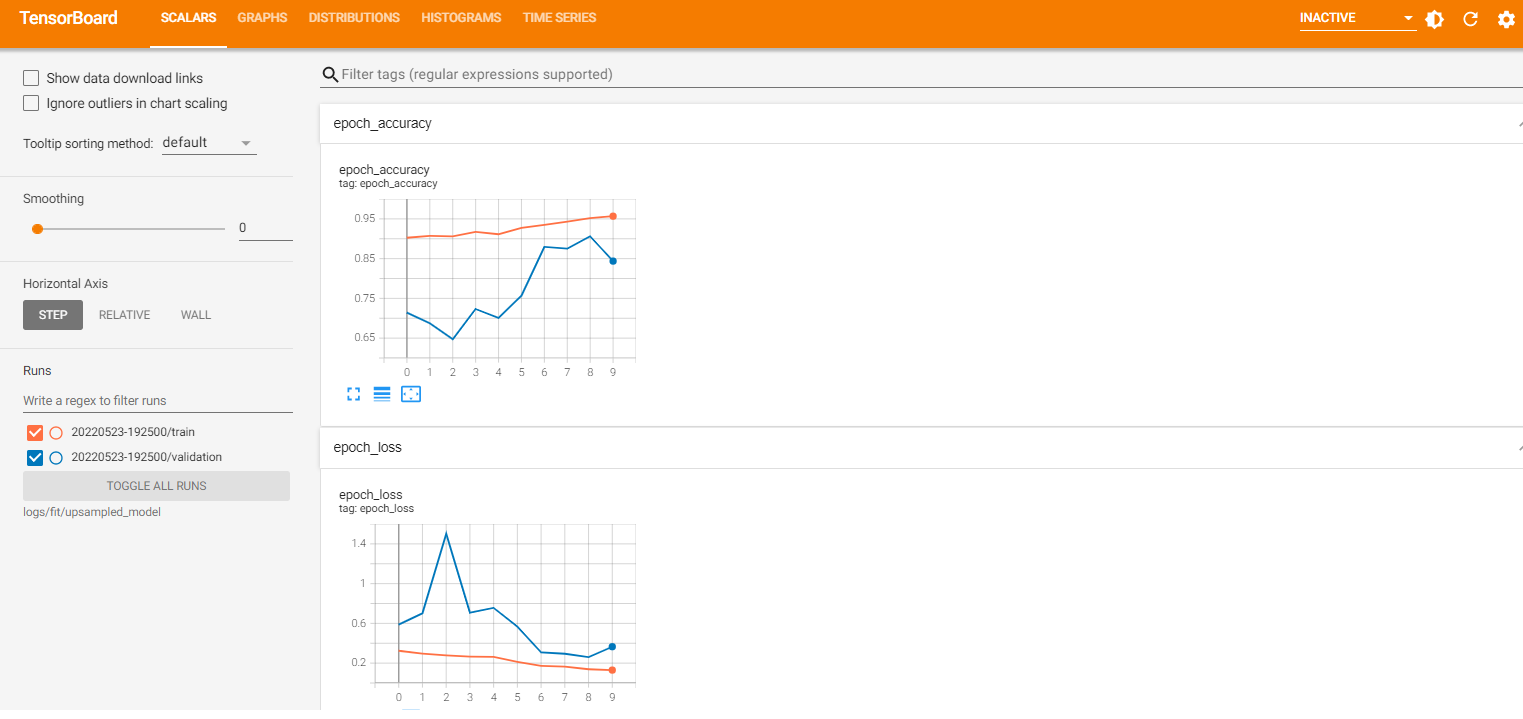

In [ ]:
Image(filename='figure5.png') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


######################################## Accuracy per Class ########################################
Test accuracy for class NORMAL is:
 0.2649572789669037
Test accuracy for class BACTERIA is:
 0.9834710955619812
Test accuracy for class Pneumonia/Viral/COVID-19 is:
 1.0


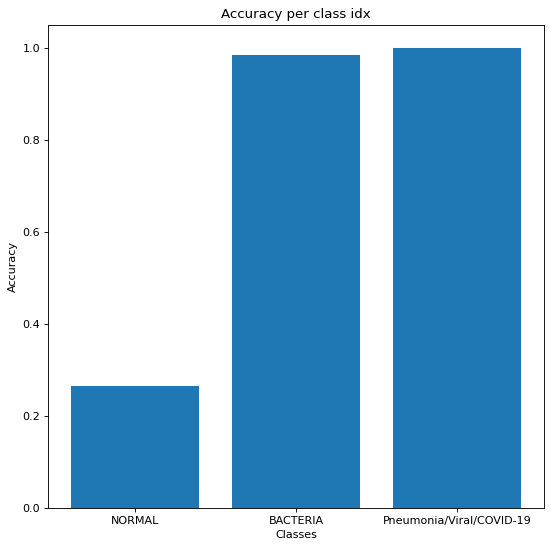

######################################## Confusion Matrix ########################################


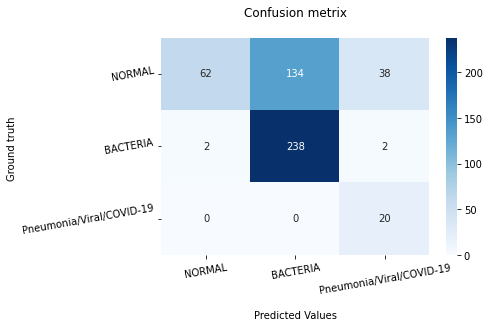

######################################## Total Acuuracy ########################################
upsampled_model test accuracy: 0.6451612710952759
                          precision    recall  f1-score   support

                  NORMAL       0.97      0.26      0.42       234
                BACTERIA       0.64      0.98      0.78       242
Pneumonia/Viral/COVID-19       0.33      1.00      0.50        20

                accuracy                           0.65       496
               macro avg       0.65      0.75      0.56       496
            weighted avg       0.78      0.65      0.59       496

######################################## Specificity ########################################
Class NORMAL specificity: 0.99
Class BACTERIA specificity: 0.47
Class Pneumonia/Viral/COVID-19 specificity: 0.92


In [ ]:
predicted_labels_upsampled, test_labels = results_printer(us_model, test_ds, finding_to_label.keys(), 'upsampled_model', print_tsne=False)

TSNE

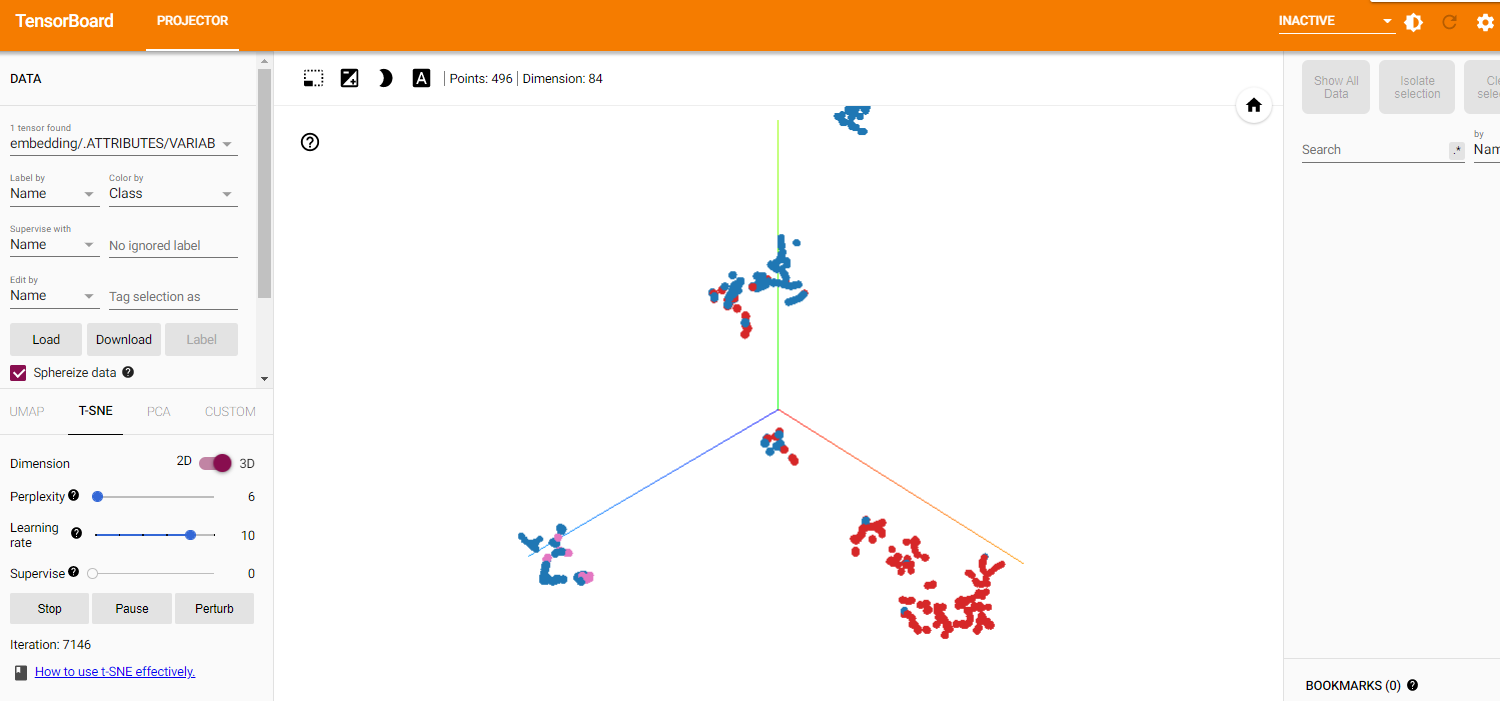

In [ ]:
Image(filename='figure6.png') 

##Class weights model

In [ ]:
log_dir_class_weights = "logs/fit/class_weights/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback_class_weights= tf.keras.callbacks.TensorBoard(log_dir=log_dir_class_weights, histogram_freq=1)

print("The class_weights model")
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
cw_model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,),
              metrics=['accuracy'])
history_class_weights = cw_model.fit(
    prepared_train_ds,
    validation_data = prepared_valid_ds,
    steps_per_epoch = len(train) // batch_size,
    validation_steps = len(valid) // batch_size,
    epochs = epoches,
    class_weight=class_weights,
    callbacks=[tensorboard_callback_class_weights]
)

The class_weights model
Epoch 1/10
112/112 [==============================] - 3s 25ms/step - loss: 0.4833 - accuracy: 0.8094 - val_loss: 0.3852 - val_accuracy: 0.8683
Epoch 2/10
112/112 [==============================] - 3s 24ms/step - loss: 0.2080 - accuracy: 0.9169 - val_loss: 0.1549 - val_accuracy: 0.9487
Epoch 3/10
112/112 [==============================] - 3s 24ms/step - loss: 0.1584 - accuracy: 0.9431 - val_loss: 0.2093 - val_accuracy: 0.9219
Epoch 4/10
112/112 [==============================] - 3s 24ms/step - loss: 0.1048 - accuracy: 0.9565 - val_loss: 0.1994 - val_accuracy: 0.9219
Epoch 5/10
112/112 [==============================] - 3s 24ms/step - loss: 0.0948 - accuracy: 0.9598 - val_loss: 0.2768 - val_accuracy: 0.8951
Epoch 6/10
112/112 [==============================] - 3s 24ms/step - loss: 0.0756 - accuracy: 0.9707 - val_loss: 0.3127 - val_accuracy: 0.8929
Epoch 7/10
112/112 [==============================] - 3s 24ms/step - loss: 0.0642 - accuracy: 0.9738 - val_loss: 0.233

In [ ]:
# %tensorboard --logdir logs/fit/class_weights

Loss and Accuracy for train and validation

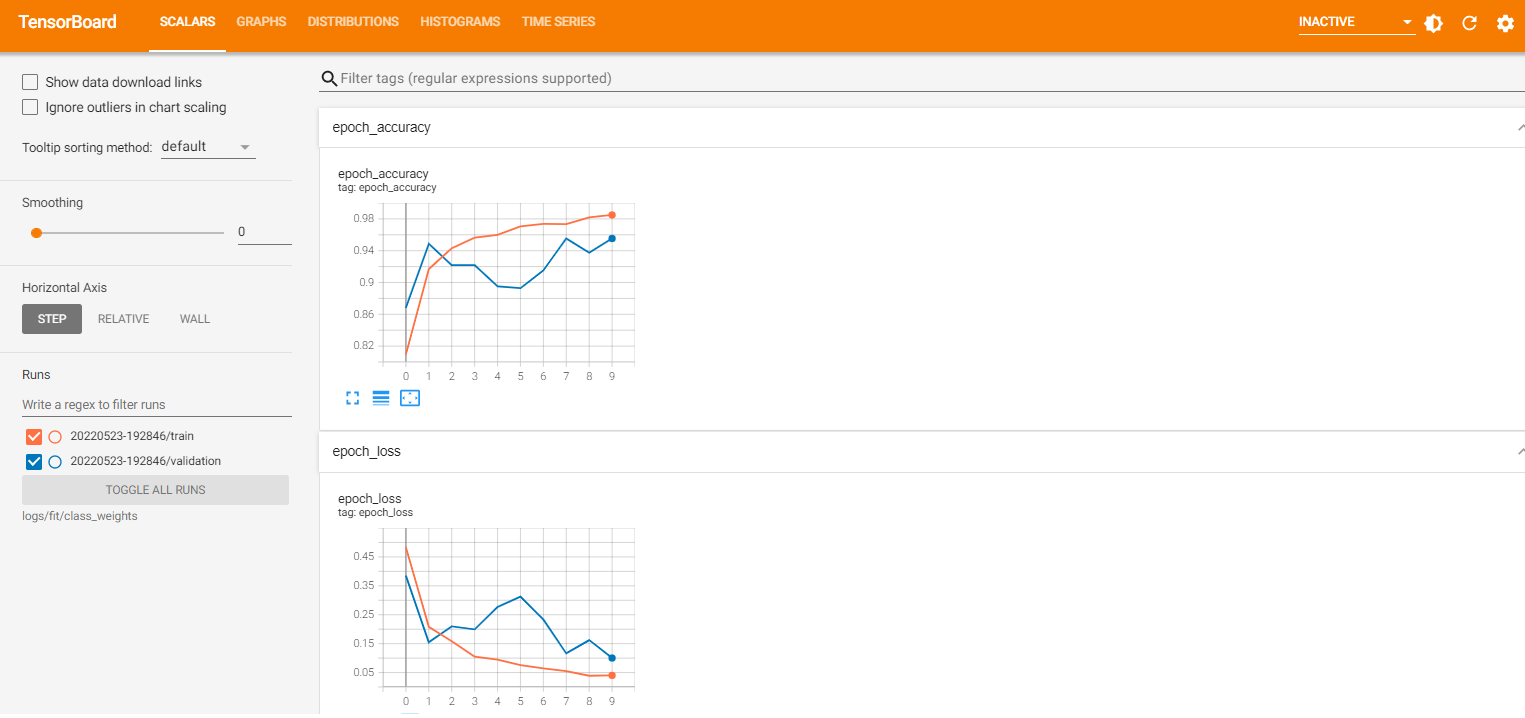

In [ ]:
Image(filename='figure7.png') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


######################################## Accuracy per Class ########################################
Test accuracy for class NORMAL is:
 0.4188034236431122
Test accuracy for class BACTERIA is:
 0.9958677887916565
Test accuracy for class Pneumonia/Viral/COVID-19 is:
 0.949999988079071


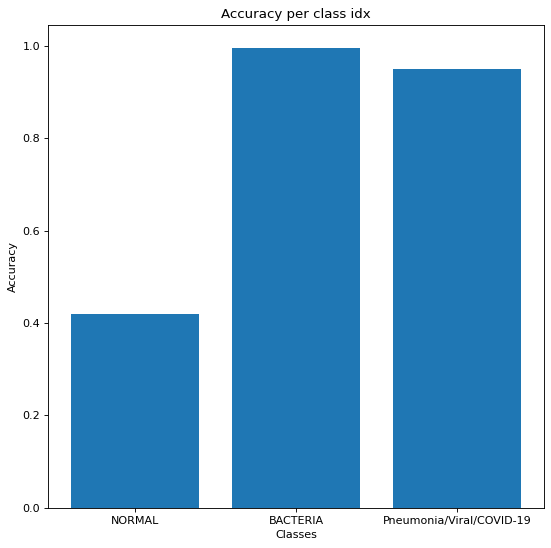

######################################## Confusion Matrix ########################################


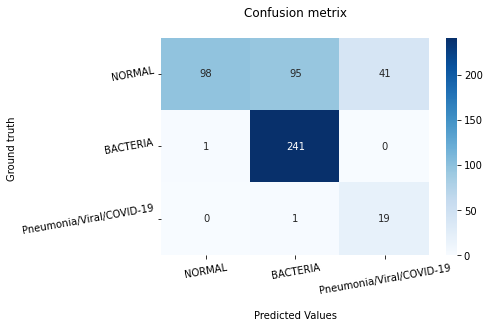

######################################## Total Acuuracy ########################################
weighted_model test accuracy: 0.7217742204666138
                          precision    recall  f1-score   support

                  NORMAL       0.99      0.42      0.59       234
                BACTERIA       0.72      1.00      0.83       242
Pneumonia/Viral/COVID-19       0.32      0.95      0.47        20

                accuracy                           0.72       496
               macro avg       0.67      0.79      0.63       496
            weighted avg       0.83      0.72      0.70       496

######################################## Specificity ########################################
Class NORMAL specificity: 1.0
Class BACTERIA specificity: 0.62
Class Pneumonia/Viral/COVID-19 specificity: 0.91


In [ ]:
predicted_labels_class_weights , test_labels = results_printer(cw_model, test_ds, finding_to_label.keys(), 'weighted_model', print_tsne=False)

TSNE

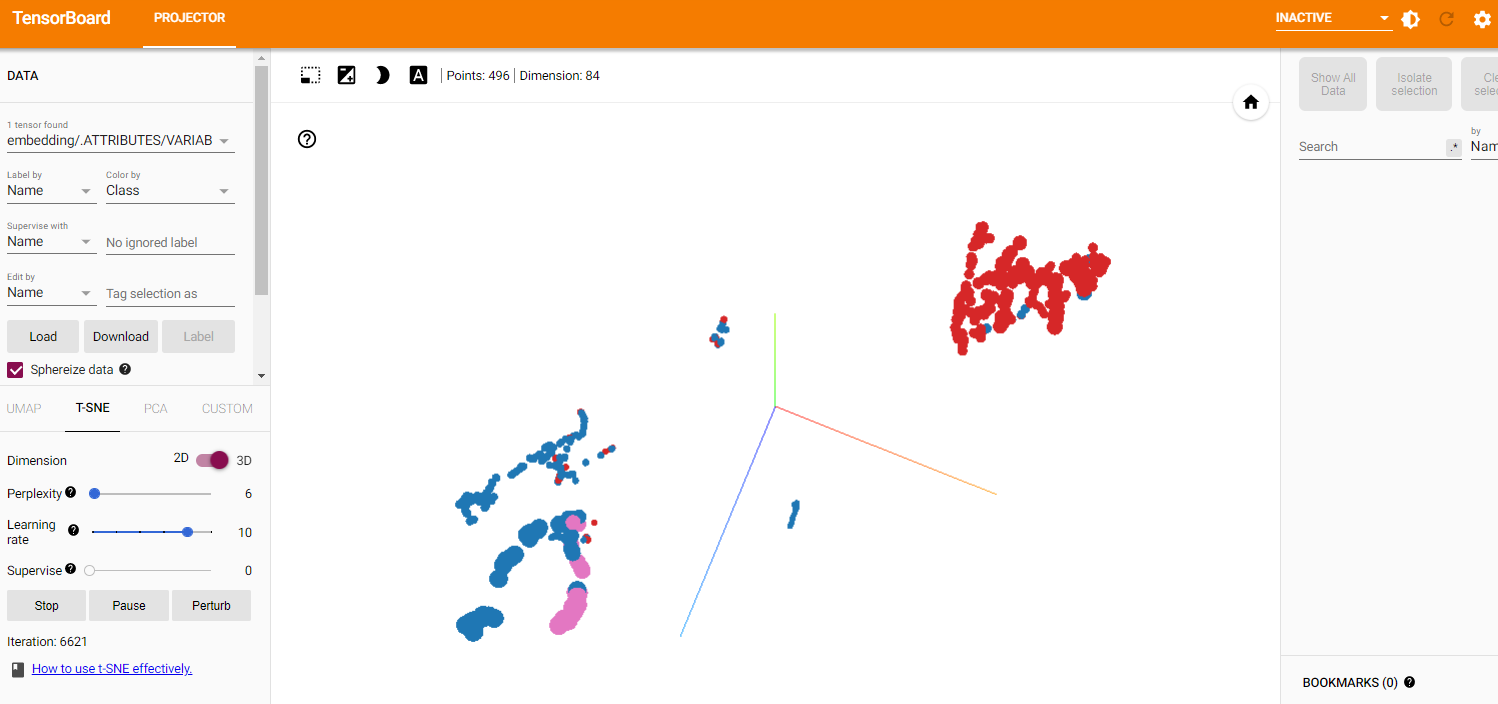

In [ ]:
Image(filename='figure8.png') 

For your classification task think about:
*  Are you overfitted? Why? What can you do?
*  Can the classes be distinguished?
*  What are the data limits? Can we filter/process it better?
*  Is it possible that we are classifying the X-Ray machine and not the case?


As we thought, because the data is imbalanced, the model with the original dataset tends to predict the majority class (BACTERIA). There is a gap between the validation/train and the test accuracy. One possible reason is that the model is imbalanced and the majority class in the training set is BACTERIA. Therefore, the model learns to assign high "prior" to this class. On the other hand, in the test set, BACTERIA, and NORMAL classes are almost of the same size. Therefore as the distribution of the validation set and the training set are similar, we have a gap between validation and test results.
With the downsampled data, the performance is the best in terms of both accuracy and F1 score. This happens as even if the dataset is smaller, it is balanced. With oversampling data, the model performs worst and is extremely overfitted and the model is hardly distinguished between the NORMAL class and the other classes. With the class weight model, the performance is better compared to the model trained over the original data (vanilla model) but, worse than the model trained with the downsampled data.
If we had access to more data, taken from different X-ray machines over the whole symptoms, the model could generalize better.
It is possible that we are classifying the X-Ray machine and not the case of COVID-19 because when we visualized the data, we observed that the data corresponding to the COVID-19 class looks different in the sense of colors/brightness. Therefore we applied augmentation of this type to try to avoid this phenomena.

The F1 score is very useful when you are dealing with imbalanced class problems. These are problems when one class can dominate the dataset.

Take the example of predicting a disease. Let’s say that only 10% of the instances in your dataset have the actual disease. This means that you could get 90% accuracy by simply predicting the negative class all the time. But, how useful is this? Not very useful, as you wouldn’t have predicted a single instance of the actual disease! This is where the F1 score can be very helpful. In this example, the recall for the positive class would be 0, and hence the F1 score would also be 0.

Therefore, according to the average F1 score, the best results were achieved with the downsampled model with an average F1 score of 0.77 (and accuracy 0.86).

# Transfer learning

transfer learning (https://www.tensorflow.org/tutorials/images/transfer_learning)

Load the pre trained ResNet-50 model and fine tune it to your data. (https://www.tensorflow.org/api_docs/python/tf/keras/applications)



In [ ]:
### load ResNet-18 with include_top=False:
### Fill in your code
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
base_model.trainable = False #freeze base model layers

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
### prepare it for training- freeze the resnet layers and add a classification head 
### Fill in your code

inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs)
#adding global average pooling layer, 3 dense layers, and 2 dropout layers in between
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(3)(x) #The number of classes

head_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_model")
head_model.compile(optimizer="Adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,), metrics=["accuracy"])
head_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                          

In [ ]:
def prepare_for_resnet(img, label):
  # resnet input layer expect to get 3 channels image. To solve this issue, we concatenated 3 copies of each image along the channel axis
  new_img = tf.keras.layers.Concatenate(axis=-1)([img,img,img])
  return new_img,label

In [ ]:
resnet_train_ds = aug_train_ds.map(prepare_for_resnet)
resnet_train_ds = prepare_for_training(resnet_train_ds)
resnet_valid_ds = valid_ds.map(prepare_for_resnet)
resnet_test_ds = test_ds.map(prepare_for_resnet)
prepared_resnet_valid_ds = prepare_for_training(resnet_valid_ds)

In [ ]:
### train the model:
### Fill in your code

log_dir_transfer = "logs/fit/transferd_model/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
tensorboard_callback_head= tf.keras.callbacks.TensorBoard(log_dir=log_dir_transfer, histogram_freq=1)

history = head_model.fit(
    resnet_train_ds,
    validation_data = prepared_resnet_valid_ds,
    steps_per_epoch = len(train) // batch_size,
    validation_steps = len(valid) // batch_size,
    epochs = epoches,
    callbacks=[tensorboard_callback_head]
)

Epoch 1/10
112/112 [==============================] - 89s 590ms/step - loss: 0.6041 - accuracy: 0.7812 - val_loss: 0.2525 - val_accuracy: 0.8795
Epoch 2/10
112/112 [==============================] - 10s 89ms/step - loss: 0.3104 - accuracy: 0.8828 - val_loss: 0.3028 - val_accuracy: 0.8795
Epoch 3/10
112/112 [==============================] - 10s 91ms/step - loss: 0.2747 - accuracy: 0.8962 - val_loss: 0.1914 - val_accuracy: 0.9241
Epoch 4/10
112/112 [==============================] - 10s 92ms/step - loss: 0.2107 - accuracy: 0.9241 - val_loss: 0.1385 - val_accuracy: 0.9531
Epoch 5/10
112/112 [==============================] - 10s 90ms/step - loss: 0.2179 - accuracy: 0.9241 - val_loss: 0.1909 - val_accuracy: 0.9263
Epoch 6/10
112/112 [==============================] - 10s 88ms/step - loss: 0.1720 - accuracy: 0.9420 - val_loss: 0.1255 - val_accuracy: 0.9531
Epoch 7/10
112/112 [==============================] - 10s 91ms/step - loss: 0.1696 - accuracy: 0.9434 - val_loss: 0.1560 - val_accuracy

Evaluate your results and compare them to your own CNN model. 

In [ ]:
# %tensorboard --logdir logs/fit/transferd_model

Loss and Accuracy for train and validation

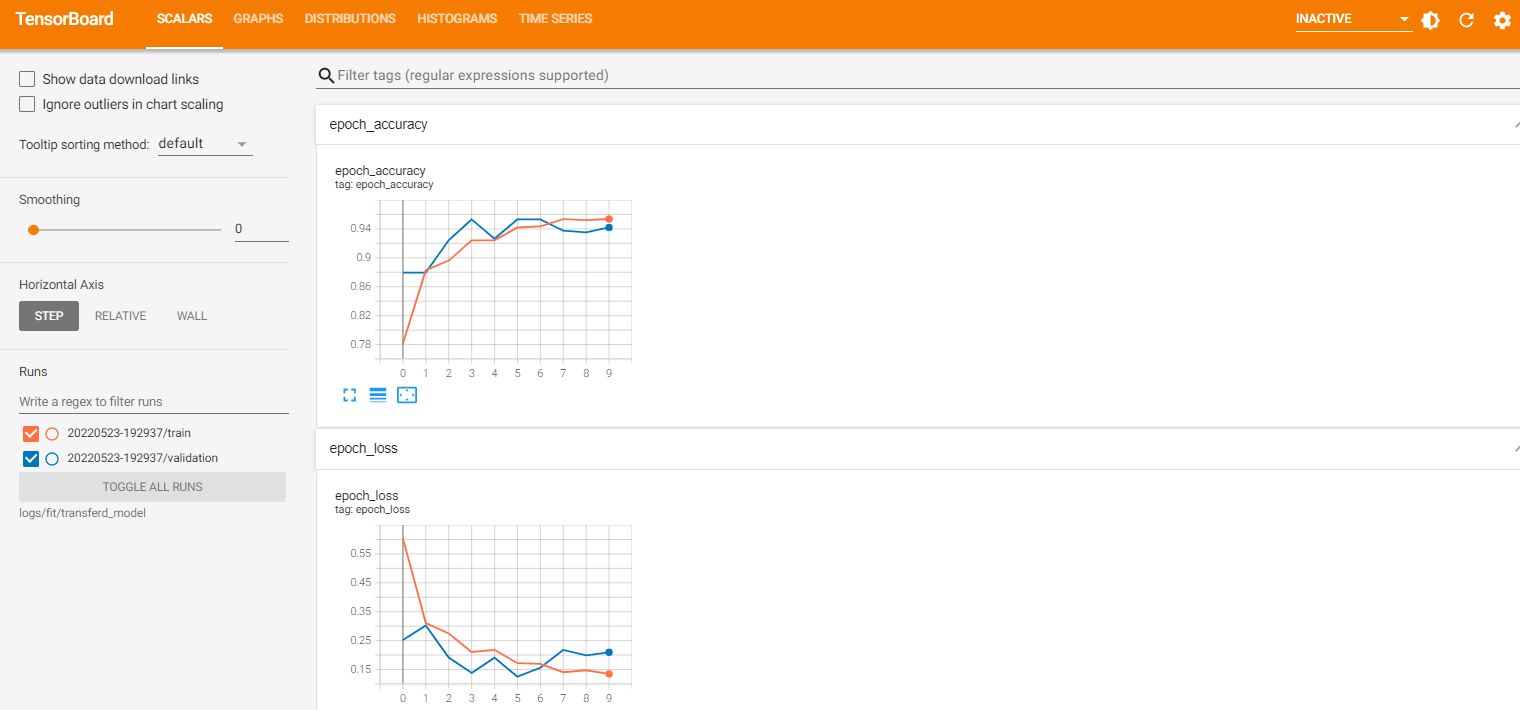

In [ ]:
Image(filename='figure9.png') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


######################################## Accuracy per Class ########################################
Test accuracy for class NORMAL is:
 0.4316239356994629
Test accuracy for class BACTERIA is:
 1.0
Test accuracy for class Pneumonia/Viral/COVID-19 is:
 1.0


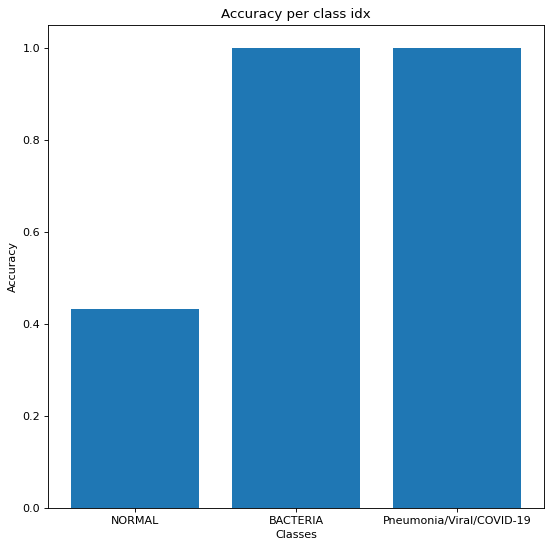

######################################## Confusion Matrix ########################################


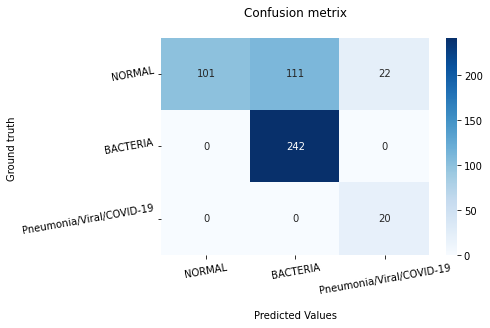

######################################## Total Acuuracy ########################################
transfer_model test accuracy: 0.7318548560142517
                          precision    recall  f1-score   support

                  NORMAL       1.00      0.43      0.60       234
                BACTERIA       0.69      1.00      0.81       242
Pneumonia/Viral/COVID-19       0.48      1.00      0.65        20

                accuracy                           0.73       496
               macro avg       0.72      0.81      0.69       496
            weighted avg       0.83      0.73      0.71       496

######################################## Specificity ########################################
Class NORMAL specificity: 1.0
Class BACTERIA specificity: 0.56
Class Pneumonia/Viral/COVID-19 specificity: 0.95


In [ ]:
predicted_labels_resnet, test_labels = results_printer(head_model, resnet_test_ds, finding_to_label.keys(), 'transfer_model', print_tsne=False)

TSNE

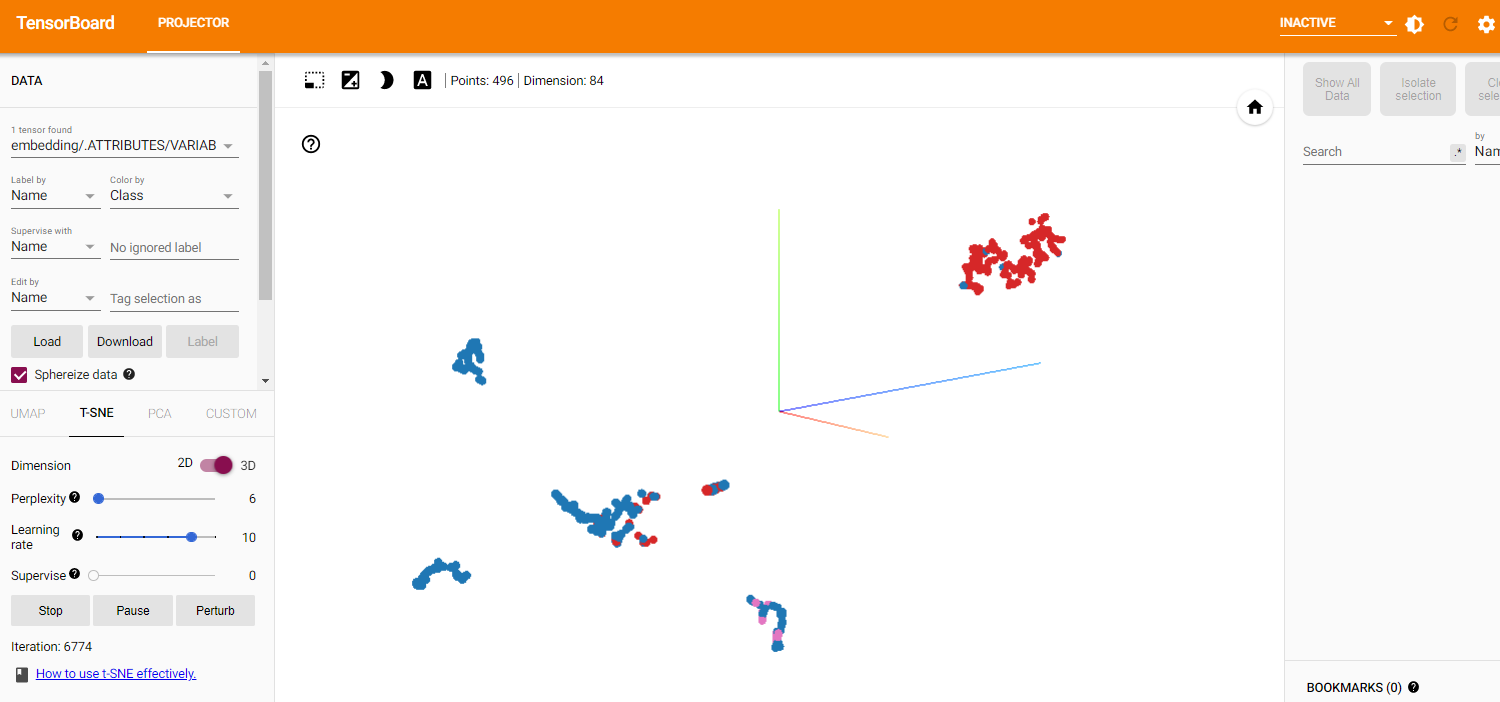

In [ ]:
Image(filename='figure10.png') 

This model achieved better results compared to the vanilla model, which is a fair comparison as they trained over the same dataset. The Resnet average F1 score is 0.69 over the test, and the accuracy is 0.73.
Even though this model contains a lot of parameters, it is trained very fast, because the number of trainable parameters is small. We thought about two reasons for this model to perform better than the vanilla model. The first is that the model uses pre-trained weights of the CNN layers that are trained over the ImageNet dataset which allows the model to extract very good features from the images. The second reason is that the model is much larger and deeper than our vanilla model. One may think that a large model such as resnet50 will perform badly as its capacity is very larger. This does not happen because we fixed most of the weight of the network and we only trained a small fraction of them. Therefore, due to the transfer learning method, we could use the advantages of the deep ResNet network without extreme overfitting.

# Test Time Augmentation

Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

## Use Test Time Augmentation
Using your choise of augmentations write your own code for test time augmentation

We chose the augmentations similar to the training set augmentations. These augmentations can help to improve accuracy because it is a kind of ensembling or majority vote. In addition, the model should be robust to those augmentations because it has trained over them.

In [ ]:
def augmentation_flip(img, label):
  aug_img=tf.image.random_flip_left_right(img)
  return aug_img,label

def augmentation_bright(img, label):
  aug_img=tf.image.random_brightness(img,0.15)
  return aug_img,label

def augmentation_gamma(img, label):
  gamma = np.random.uniform(low=0.9, high=1.1, size=[1,])
  aug_img=tf.image.adjust_gamma(img, gamma=gamma[0], gain=1)
  return aug_img,label

  

In [ ]:
#Apply augmentations
aug_test_ds_flip = test_ds.map(augmentation_flip)
aug_test_ds_bright = test_ds.map(augmentation_bright)
aug_test_ds_gamma = test_ds.map(augmentation_gamma)

In [ ]:
#extracting images only from the df dataset
test_images_flip = np.concatenate([np.expand_dims(x, axis=0) for x, y in aug_test_ds_flip], axis=0)
test_images_bright = np.concatenate([np.expand_dims(x, axis=0) for x, y in aug_test_ds_bright], axis=0)
test_images_gamma = np.concatenate([np.expand_dims(x, axis=0) for x, y in aug_test_ds_gamma], axis=0)

In [ ]:
# We choose the downsampled weigthed model 
true_guess = 0 #counting successful predictions
true_guess_class = {0:0, 1:0, 2:0} #counting successful predictions per class
predicted_images = []
for idx in range(len(test_images_flip)):
    test_images_total = np.array([test_images_flip[idx], test_images_gamma[idx] ,test_images_bright[idx]]) #augmented test image
    label_images_total = np.array([test_labels[idx],test_labels[idx],test_labels[idx]]) # labels
    predicted_labels_basic = tf.reduce_mean(tf.nn.softmax(ds_model.predict(test_images_total)), 0) #predicting image for each augmentation
    max_key = tf.argmax(predicted_labels_basic)
    if max_key == test_labels[idx]:
        true_guess += 1
        true_guess_class[test_labels[idx]] += 1
    predicted_images.append(max_key)

In [ ]:
accuracy_aug = true_guess / len(test_images_flip)
print(f"The accuracy of the model with the augmented test images is : {accuracy_aug}")

The accuracy of the model with the augmented test images is : 0.875


######################################## Accuracy per Class ########################################
Test accuracy for class number 0 is:
 0.8162393162393162
Test accuracy for class number 1 is:
 0.9214876033057852
Test accuracy for class number 2 is:
 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


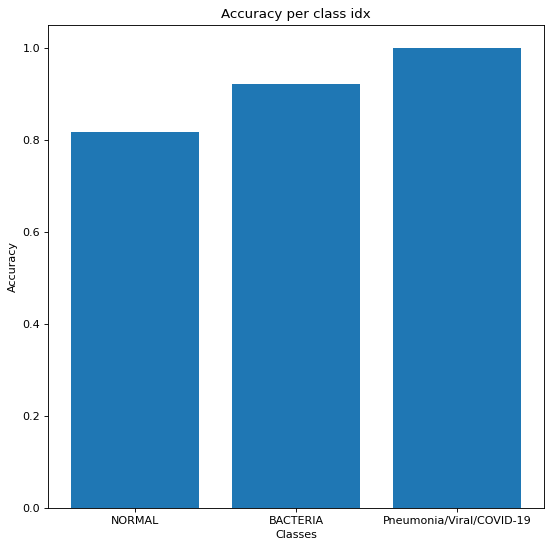

######################################## Confusion Matrix ########################################


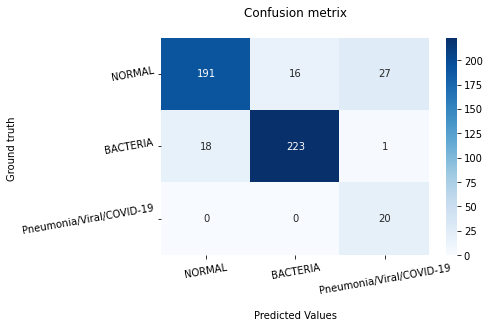

######################################## Recall & Precision & F1 Score ########################################
                          precision    recall  f1-score   support

                  NORMAL       0.91      0.82      0.86       234
                BACTERIA       0.93      0.92      0.93       242
Pneumonia/Viral/COVID-19       0.42      1.00      0.59        20

                accuracy                           0.88       496
               macro avg       0.75      0.91      0.79       496
            weighted avg       0.90      0.88      0.88       496

######################################## Specificity ########################################
Per class specificity:  [0.93 0.94 0.94]


In [ ]:
test_images = np.concatenate([np.expand_dims(x, axis=0) for x, y in test_ds], axis=0)
test_labels = np.concatenate([[y.numpy()] for x, y in test_ds], axis=0)

test_images_list, label_list = class_splitter(test_images,  test_labels)

countered_labels = Counter(np.array(test_labels))
acc_normal = true_guess_class[0] / countered_labels[0]
acc_bact = true_guess_class[1] / countered_labels[1]
acc_covid = true_guess_class[2] / countered_labels[2]

acc_per_class_vec = [acc_normal, acc_bact, acc_covid]

predicted_images = np.array(predicted_images)

print('#'*40+' Accuracy per Class '+ '#'*40)
for label in range(len(classes_names)):
    print(f'Test accuracy for class number {label} is:\n', acc_per_class_vec[label])
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Accuracy per class idx")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.bar(classes_names , acc_per_class_vec)
plt.show() 

print('#'*40+' Confusion Matrix '+ '#'*40)

confusion_matrix_plot(test_labels, predicted_images, classes_names)

print('#'*40+' Recall & Precision & F1 Score '+ '#'*40)

print(classification_report(test_labels, predicted_images, target_names=classes_names))

print('#'*40+' Specificity '+ '#'*40)
Specificity = calculate_specificity(test_labels, predicted_images)
print('Per class specificity: ', Specificity)



## Compare your test results with those of the previous sections   

As we expected, using test data augmentation, the results are improved. For comparison, in the downsampled model, the F1 score was improved from 0.77 to 0.79, and the accuracy was improved from 0.86 to 0.875. These are the best results over all our previous experiments.

Exporting the code to PDF

In [11]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/main.ipynb ./

In [40]:
!jupyter nbconvert --to PDF "main.ipynb"

[NbConvertApp] Converting notebook main.ipynb to PDF
[NbConvertApp] Support files will be in main_files/
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Making directory ./main_f